# HL_PN_ORN_PCA

In [1]:
from __future__ import division
import sys
import random
import copy
import math
import json

import numpy as np
import pandas as pd
import scipy

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns

sys.path.append("../resources/")
import sct
reload(sct)

sns.set_style("ticks")
sns.set_context("talk")

output_dir = "out/"
output_suffix = ""
output_formats = [".png", ".pdf"]

def save_figure(fig, name):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format)
    return None

mpl.rc('savefig', dpi=300)

pd.options.mode.chained_assignment = None  # default='warn'

# Load data

In [2]:
#Load data and libs
df_logCPM_all = pd.read_csv("../data/htseq_logCPM_hq.tab.gz", sep="\t", header=0, index_col=0) # CPM

In [3]:
df_libs = pd.read_csv("../data/libs_color3_batch.csv", sep=",", header=0, index_col=0) # sample info

# Filter for cells (nSyb_48h_ORN, GH146_PN)

In [4]:
# Load names of high quality neurons (3/6 markers), cutoff 
names_hq_neurons = []
with open ("../data/names_hq_neurons.txt") as f:
    for line in f:
        names_hq_neurons.append(line.rstrip())
        
# Get names of GH146+ PNs
selector = ((df_libs["genotype"] == "GH146-GFP") & (df_libs["num_cells"] ==1))
names_PN = [x for x in list(df_logCPM_all.columns) if x in df_libs.loc[selector].index and x in names_hq_neurons]
print ("PNs", len(names_PN))

# Get names of ORNs
selector0 = (df_libs["label"] == "nSyb_48h_ORN_P0") 
selector1 = (df_libs["label"] == "nSyb_48h_ORN_P1")
selector2 = (df_libs["label"] == "nSyb_48h_ORN_P2")
selector3 = (df_libs["label"] == "nSyb_48h_ORN_P4")
names_ORN = [x for x in list(df_logCPM_all.columns) if ((x in df_libs.loc[selector0].index) 
                      or (x in df_libs.loc[selector1].index) 
                      or (x in df_libs.loc[selector2].index)
                      or (x in df_libs.loc[selector3].index))
                      and x in names_hq_neurons]
print ("ORN", len(names_ORN))

# Get names new P4 85A10_ORNs
selector = (df_libs["label"] == "85A10_48h_ORN_P4") 
names_85A10_ORN = [x for x in list(df_logCPM_all.columns) if ((x in df_libs.loc[selector].index) and x in names_hq_neurons)]
print ("New_85A10_ORN_P4", len(names_85A10_ORN))

# Get names AM29_ORNs
selector = (df_libs["label"] == "Am29_48h_ORN_P4") 
names_AM29_ORN = [x for x in list(df_logCPM_all.columns) if ((x in df_libs.loc[selector].index) and x in names_hq_neurons)]
print ("AM29_ORN", len(names_AM29_ORN))

('PNs', 976)
('ORN', 908)
('New_85A10_ORN_P4', 63)
('AM29_ORN', 45)


In [5]:
# Filter for these cells
names_PN_nsyb_ORN = names_PN + names_ORN 
names_All_ORN = names_ORN + names_85A10_ORN +names_AM29_ORN
names_PN_All_ORN = names_PN + names_All_ORN

df_PN = df_logCPM_all[list(names_PN)]
df_PN_ORN = df_logCPM_all[list(names_PN_All_ORN)]
df_All_ORN = df_logCPM_all[list(names_All_ORN)]

df_AM29_ORN = df_logCPM_all[list(names_AM29_ORN)]
df_85A10_ORN = df_logCPM_all[list(names_85A10_ORN)]

print ("PN:", df_PN.shape[1])
print ("PN_All_ORN:", df_PN_ORN.shape[1])
print ("ORN_All:", df_All_ORN.shape[1])
print ("AM29_ORN:", df_AM29_ORN.shape[1])
print ("85A10_ORN:", df_85A10_ORN.shape[1])

# Display number of cells of each genotype to confirm
#df_libs.loc[df.columns]["genotype"].value_counts()

('PN:', 976)
('PN_All_ORN:', 1992)
('ORN_All:', 1016)
('AM29_ORN:', 45)
('85A10_ORN:', 63)


In [6]:
# Rename df for convenience
X_ORN = df_All_ORN
X_PN_ORN = df_PN_ORN
X_AM29_ORN = df_AM29_ORN
X_85A10_ORN = df_85A10_ORN

print "ORN:", X_ORN.shape[1]
print "AM29_ORN:", X_AM29_ORN.shape[1]
print "85A10_ORN:", X_85A10_ORN.shape[1]
print "PN_ORN_all:", X_PN_ORN.shape[1]

ORN: 1016
AM29_ORN: 45
85A10_ORN: 63
PN_ORN_all: 1992


# PN&ORN: Display cells using PCA/TSNE on DE genes 

In [8]:
# Rename df for convenience
X_ORN = df_All_ORN
X = df_PN_ORN

#print "ORN:", X_ORN.shape[1]
#print "PN_ORN_all:", X.shape[1]

In [9]:
#reload de_libs for ploting proper colors
df_libs = pd.read_csv("../data/libs_color3_PN_ORN.csv", sep=",", header=0, index_col=0) # sample info

In [10]:
df_specificGenes = pd.read_csv("../data/df_DE_ORN_PN_.csv", header=0, index_col=0)
Z = X.loc[df_specificGenes.index[0:500]]
#Z = X.loc[df_specificGenes.index[0:100]]

Z.shape

(500, 1992)

[t-SNE] Computing 103 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1992
[t-SNE] Computed conditional probabilities for sample 1992 / 1992
[t-SNE] Mean sigma: 0.063276
[t-SNE] Iteration 25: error = 2.1927588, gradient norm = 0.0121278
[t-SNE] Iteration 50: error = 1.9431698, gradient norm = 0.0082082
[t-SNE] Iteration 75: error = 1.3867530, gradient norm = 0.0026602
[t-SNE] Iteration 100: error = 1.3110389, gradient norm = 0.0021941
[t-SNE] Error after 100 iterations with early exaggeration: 1.311039
[t-SNE] Iteration 125: error = 1.1993043, gradient norm = 0.0016215
[t-SNE] Iteration 150: error = 1.1670527, gradient norm = 0.0014497
[t-SNE] Iteration 175: error = 1.1594592, gradient norm = 0.0014142
[t-SNE] Iteration 200: error = 1.1574140, gradient norm = 0.0014054
[t-SNE] Iteration 225: error = 1.1568582, gradient norm = 0.0014031
[t-SNE] Iteration 250: error = 1.1567005, gradient norm = 0.0014023
[t-SNE] Iteration 275: error = 1.1566596, gradient

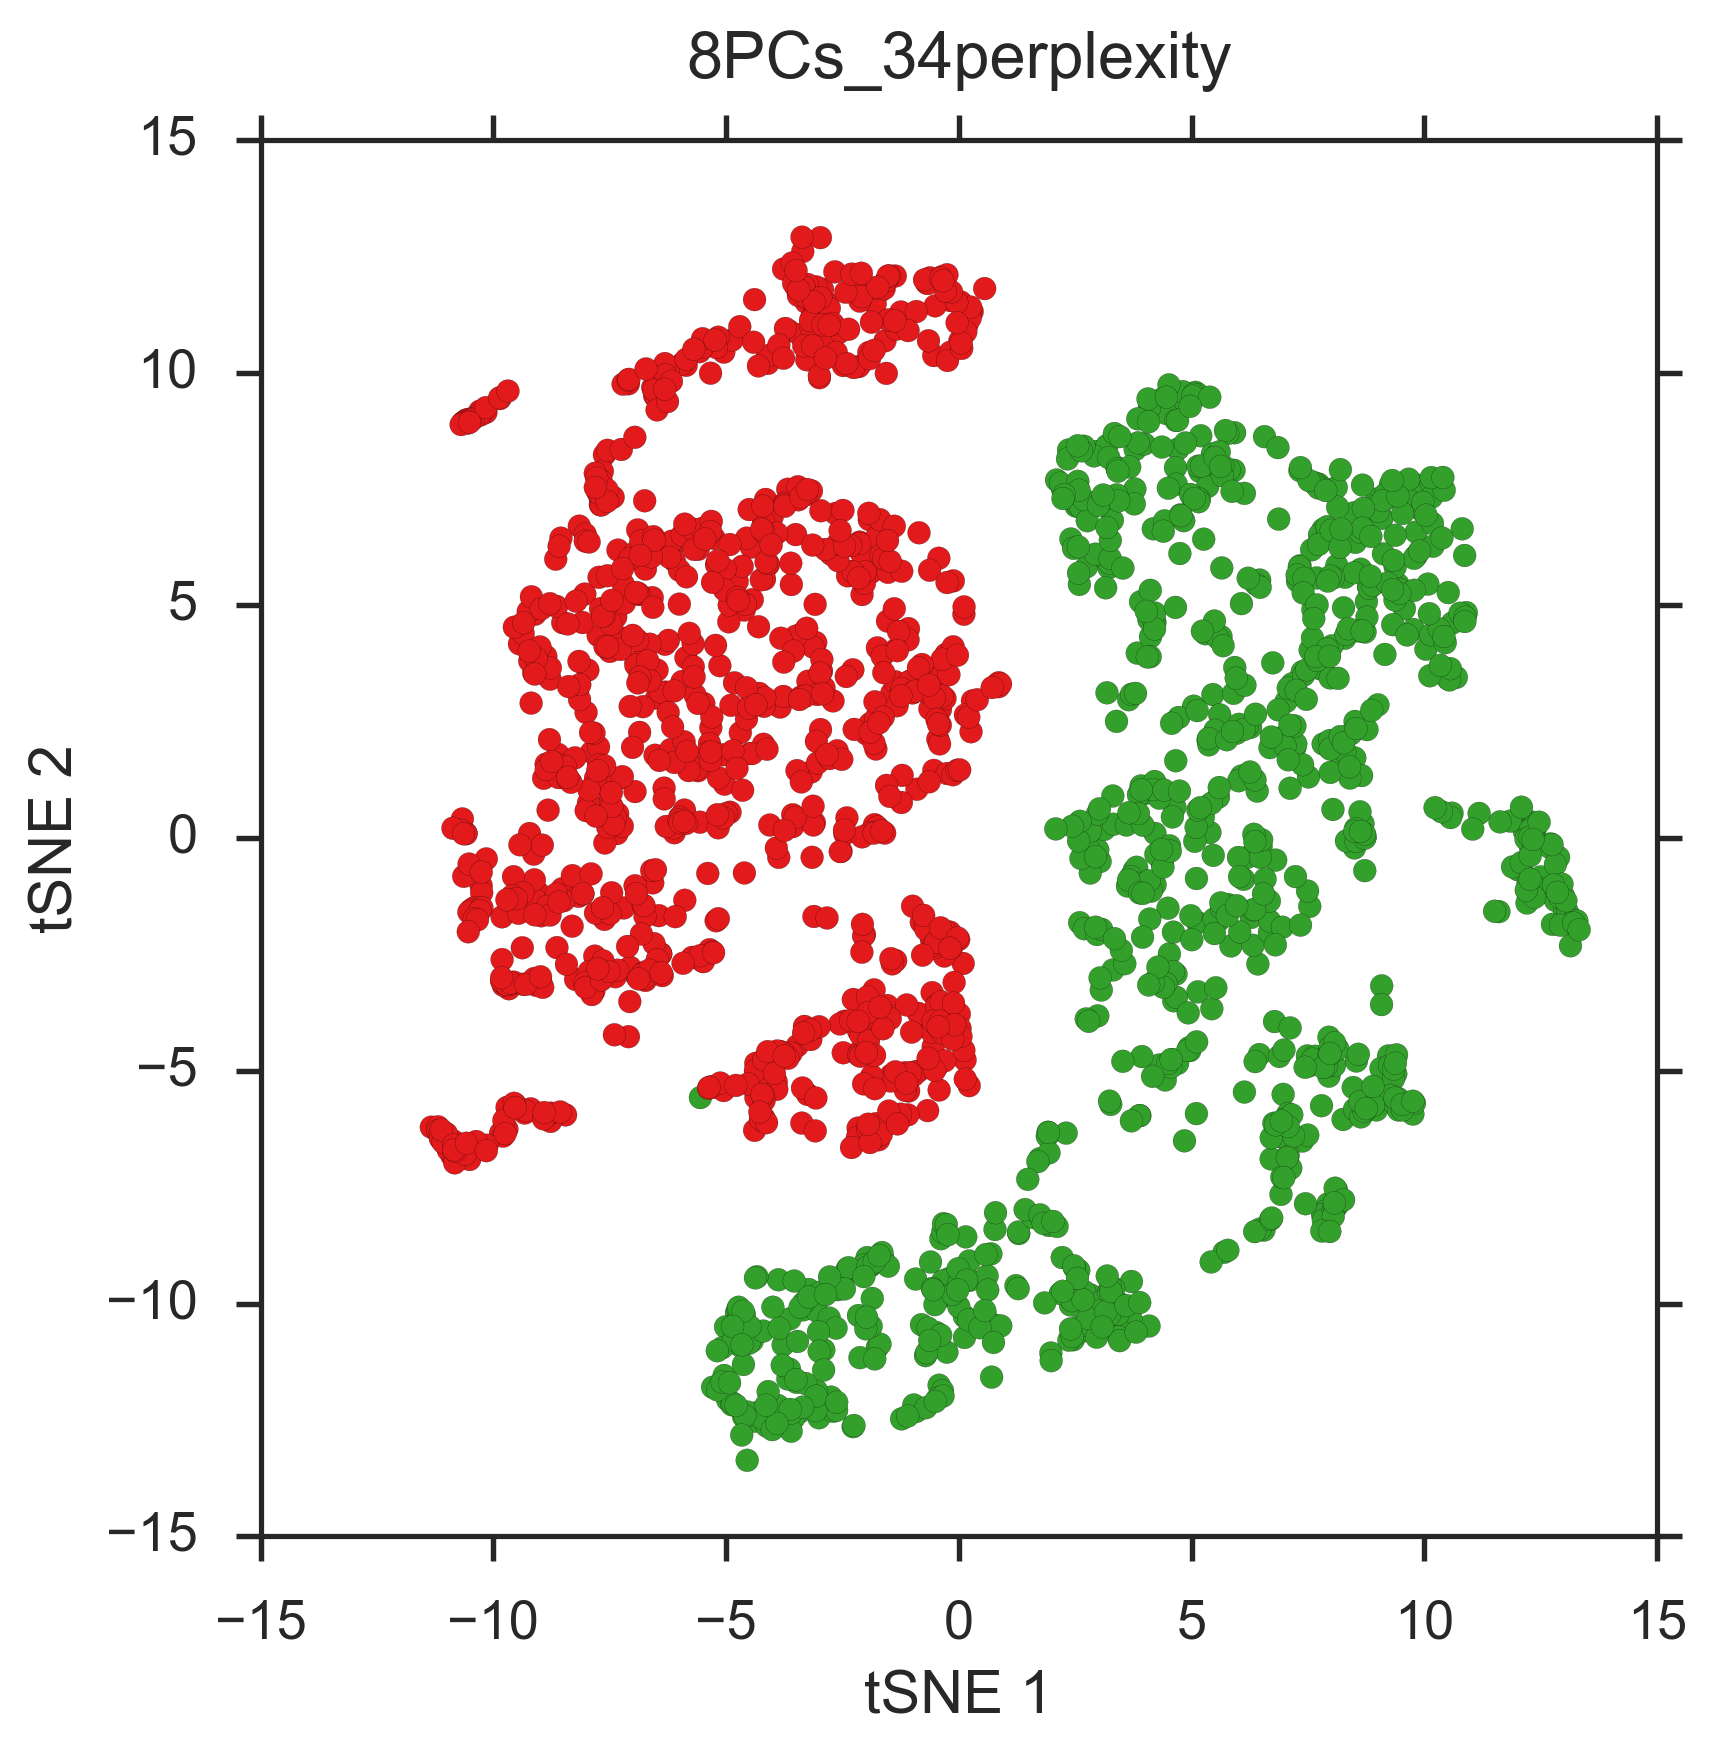

In [11]:
# Calculate PCA
from sklearn.decomposition import PCA

for i in range(8,9):
    myPCA = sct.PCA(Z, X, i) # number of significant PCs was determined using shuffling performed elsewhere in parallel fashion
    myPCA.pca()
    Z_pca = pd.DataFrame(myPCA.X_pca.T)

    for j in range(34,35):
        #reload(sct)
        from sklearn.manifold import TSNE
        myTSNE = sct.TSNE(Z_pca, X, df_libs)
        myTSNE.calc_TSNE(perplexity=j, learning_rate=500)
        # Plot TSNE
        fig, ax = plt.subplots(1, 1, figsize=(6,6))
        myTSNE.plot(fig, ax, colorMode="genotype")
        ax.set_title(str(i)+"PCs_" + str(j) +"perplexity" , y=1.03)
        fig.savefig("../Figure/Fig_1/Fig1_PCA_" + str(i) +"_PCs_" + str(j) + "_perplexity" + "_top500_lr500.pdf")

# Plot expression of selected genes

In [13]:
# myGenes = df_specificGenes.index[0:3]
myGenes = ["Oaz","CG42336", "CG3822", "peb", "CG14367", "nompB"]

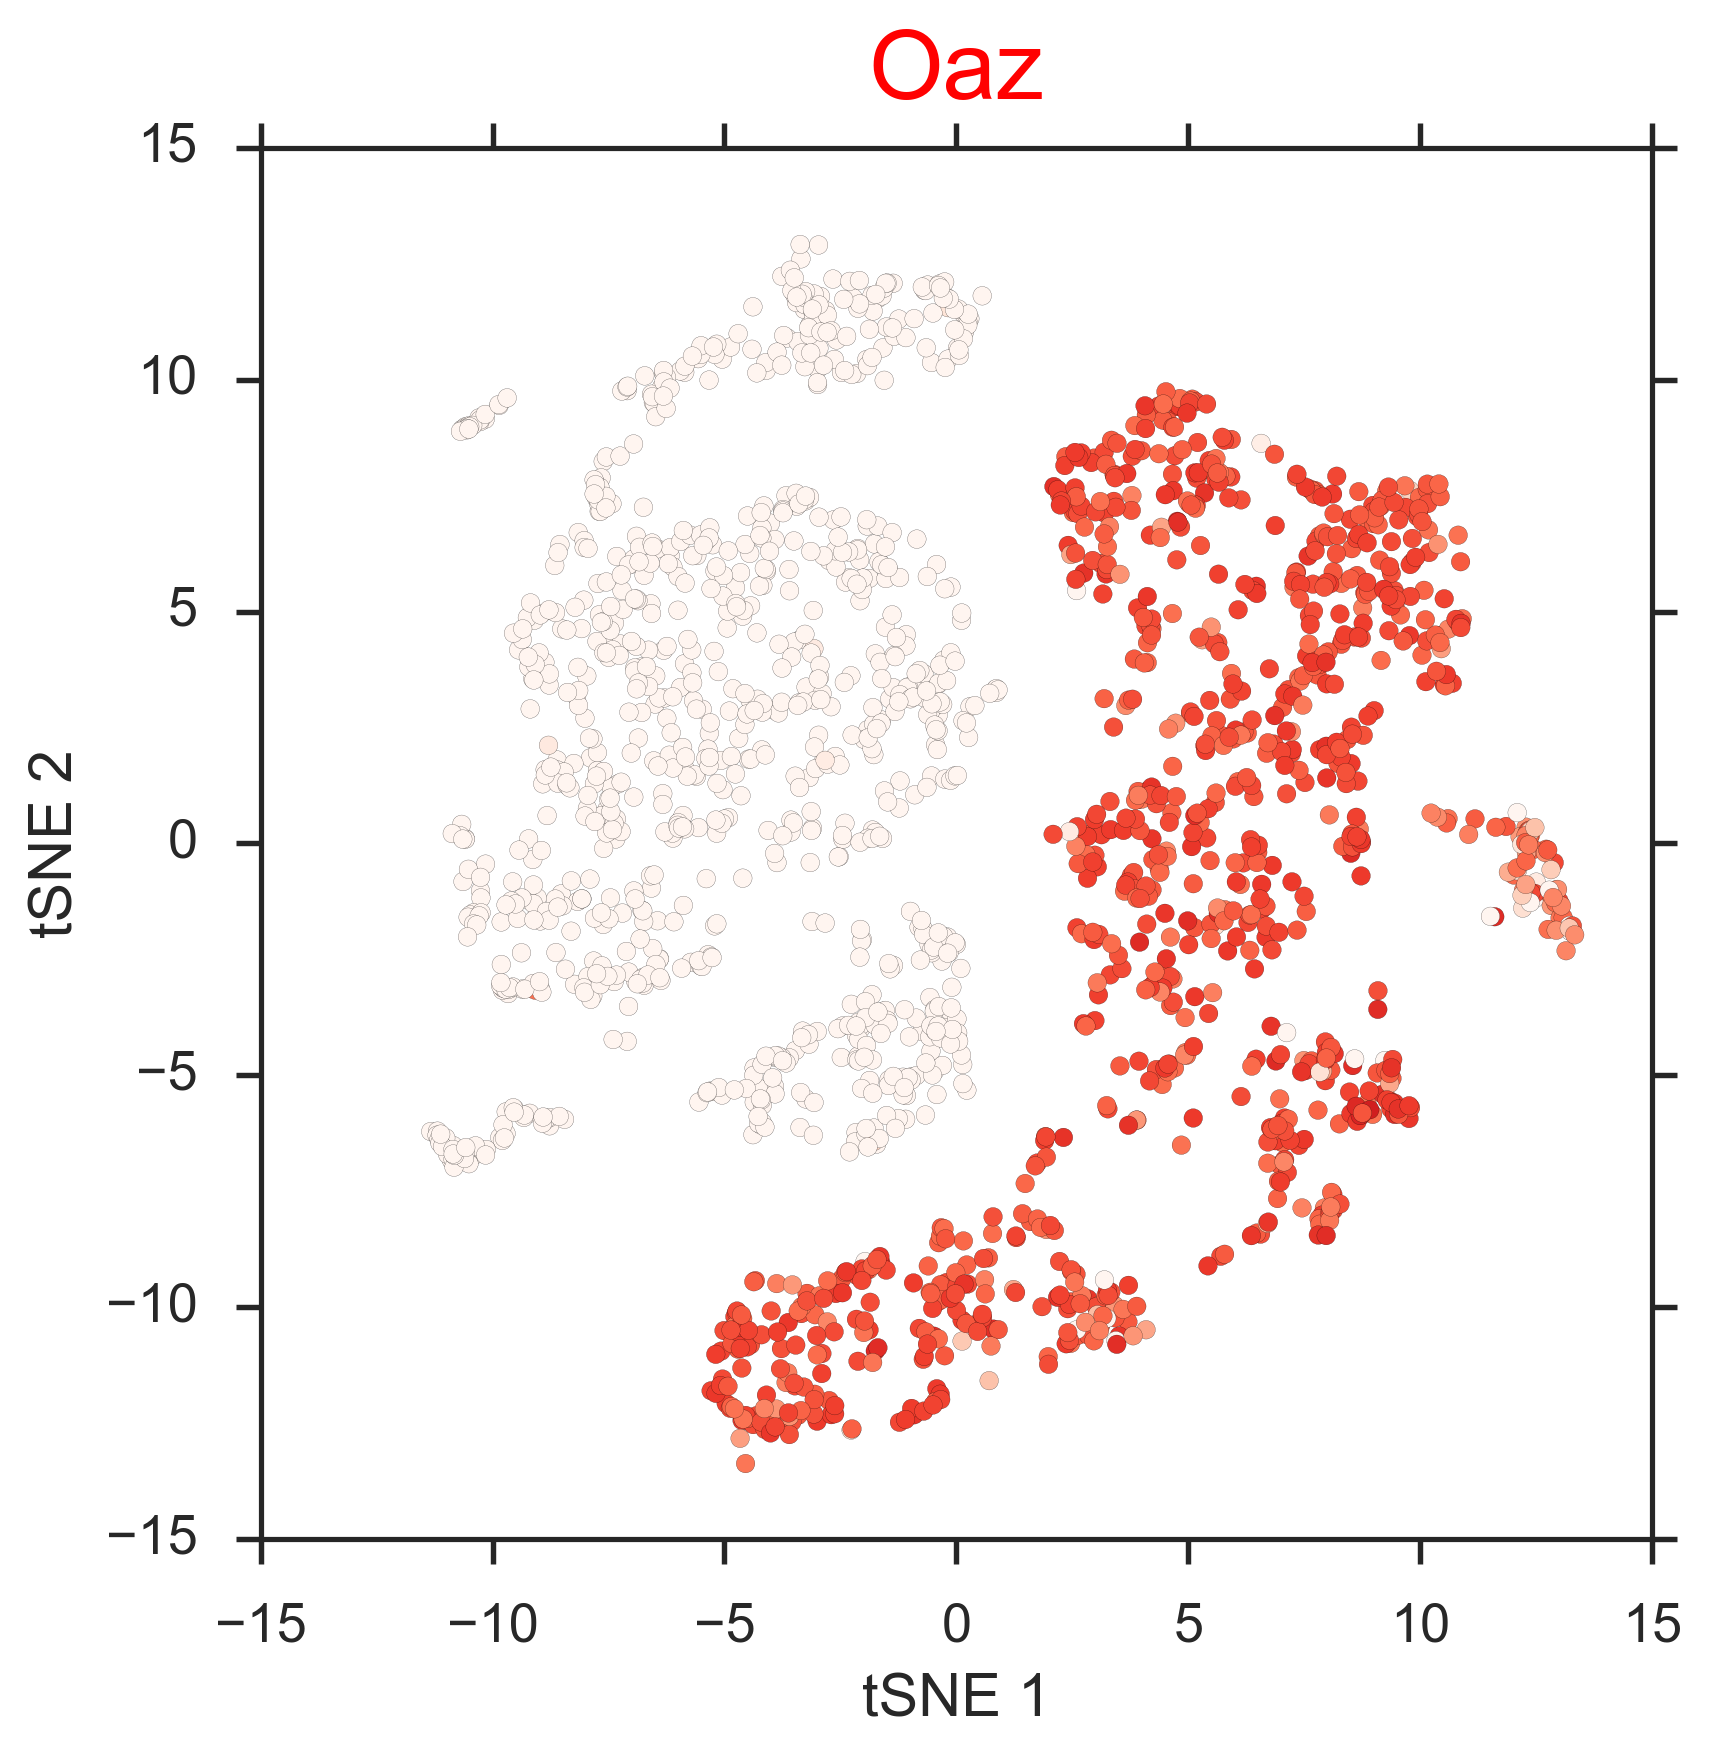

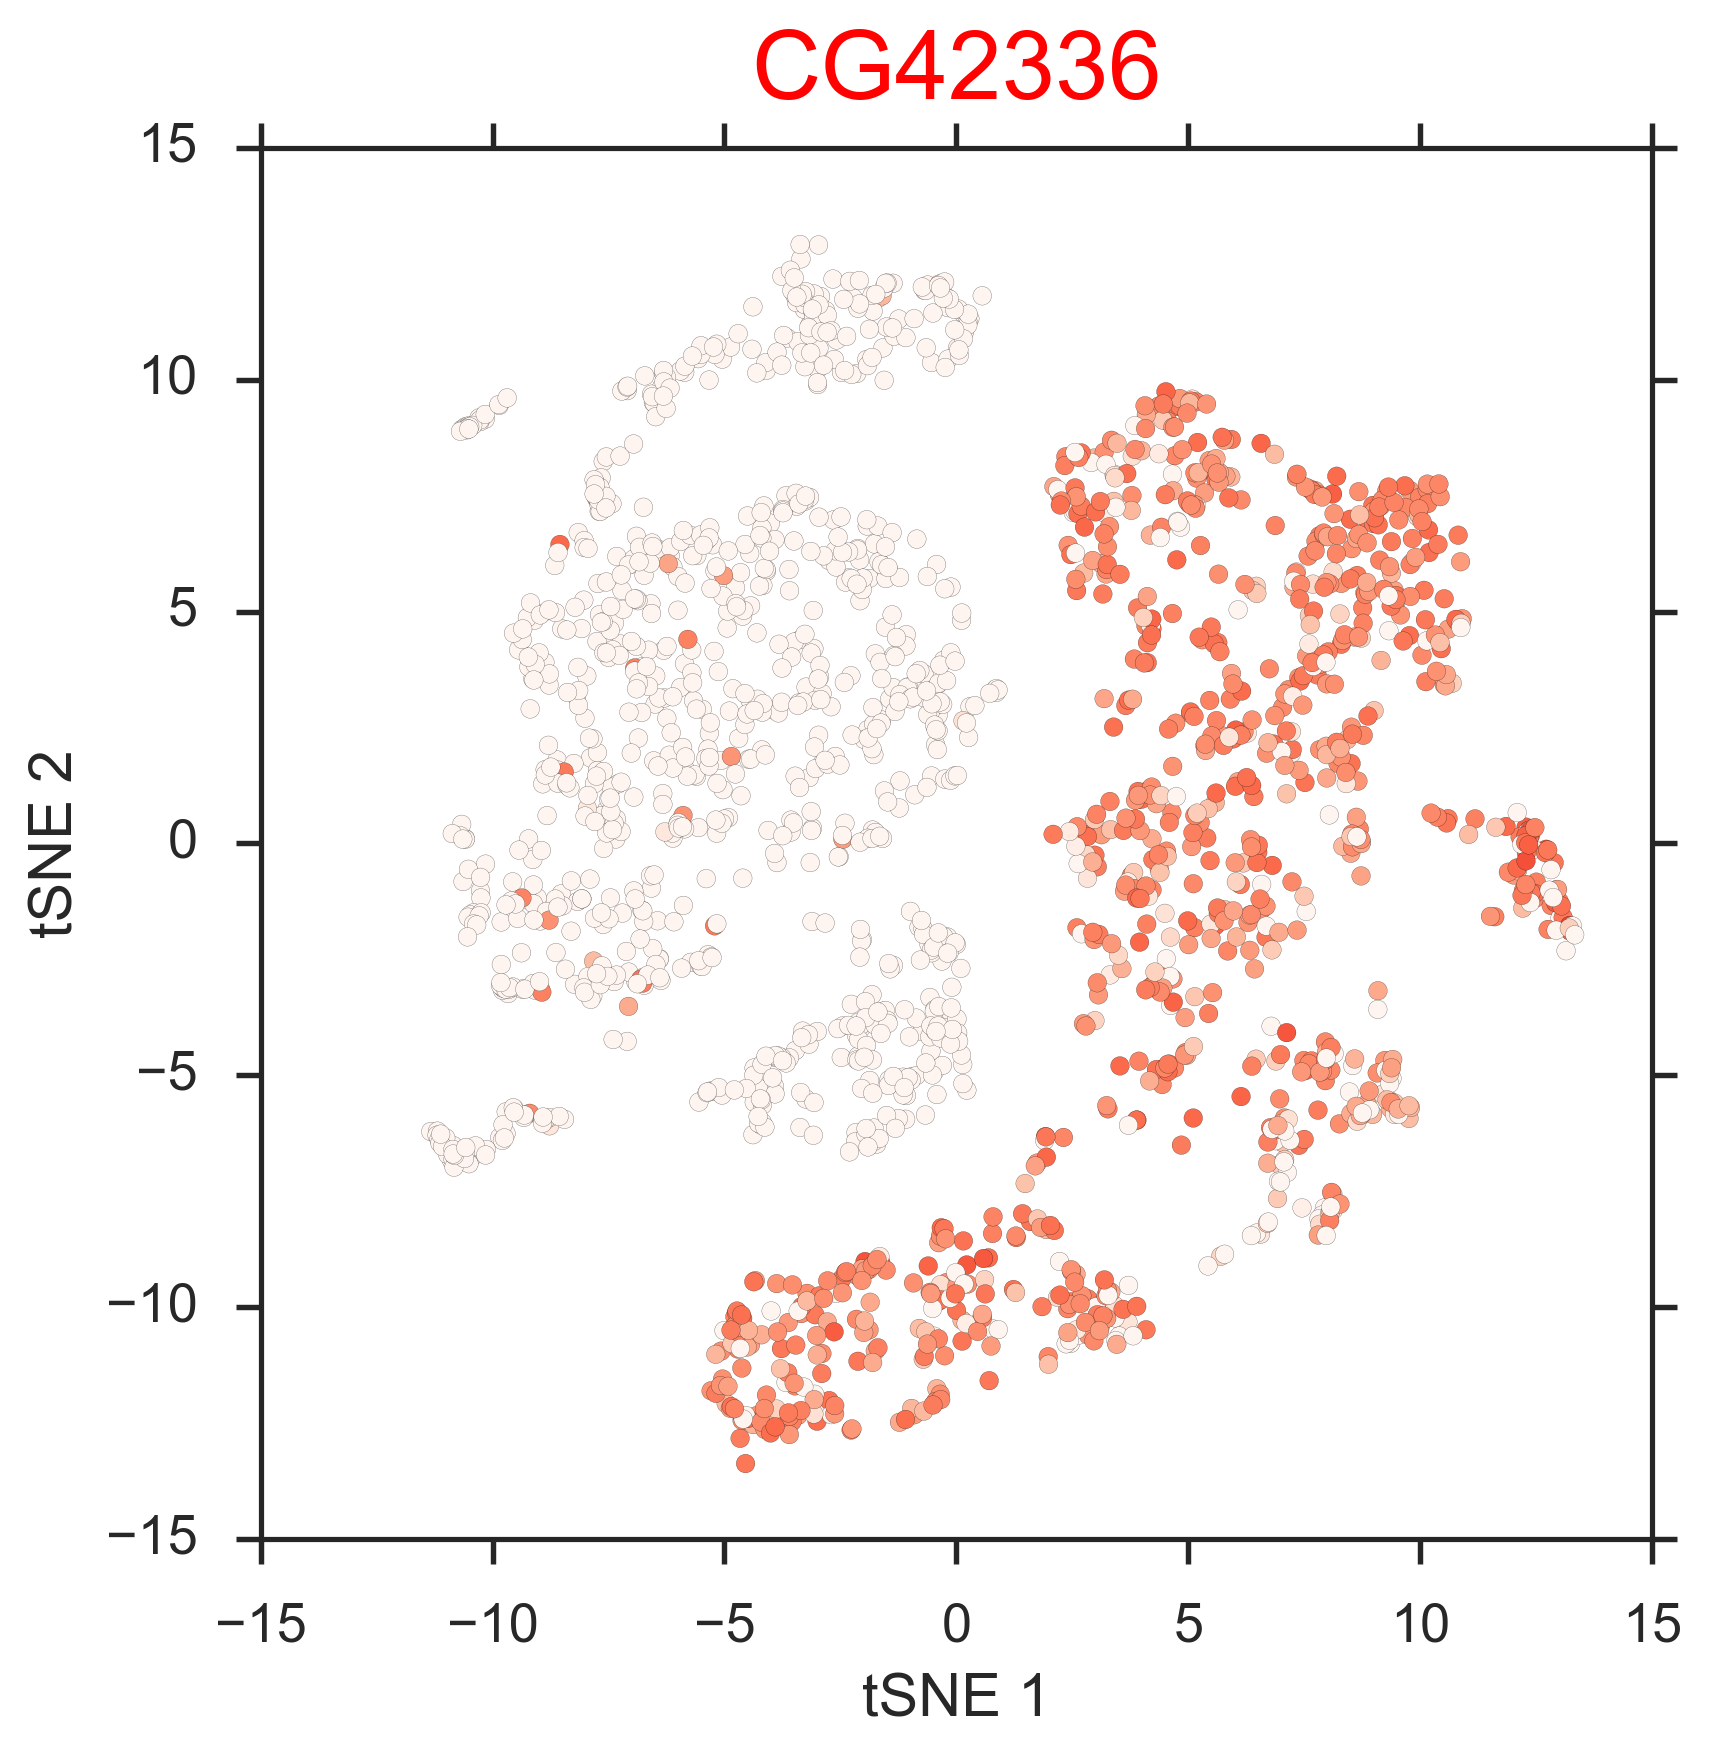

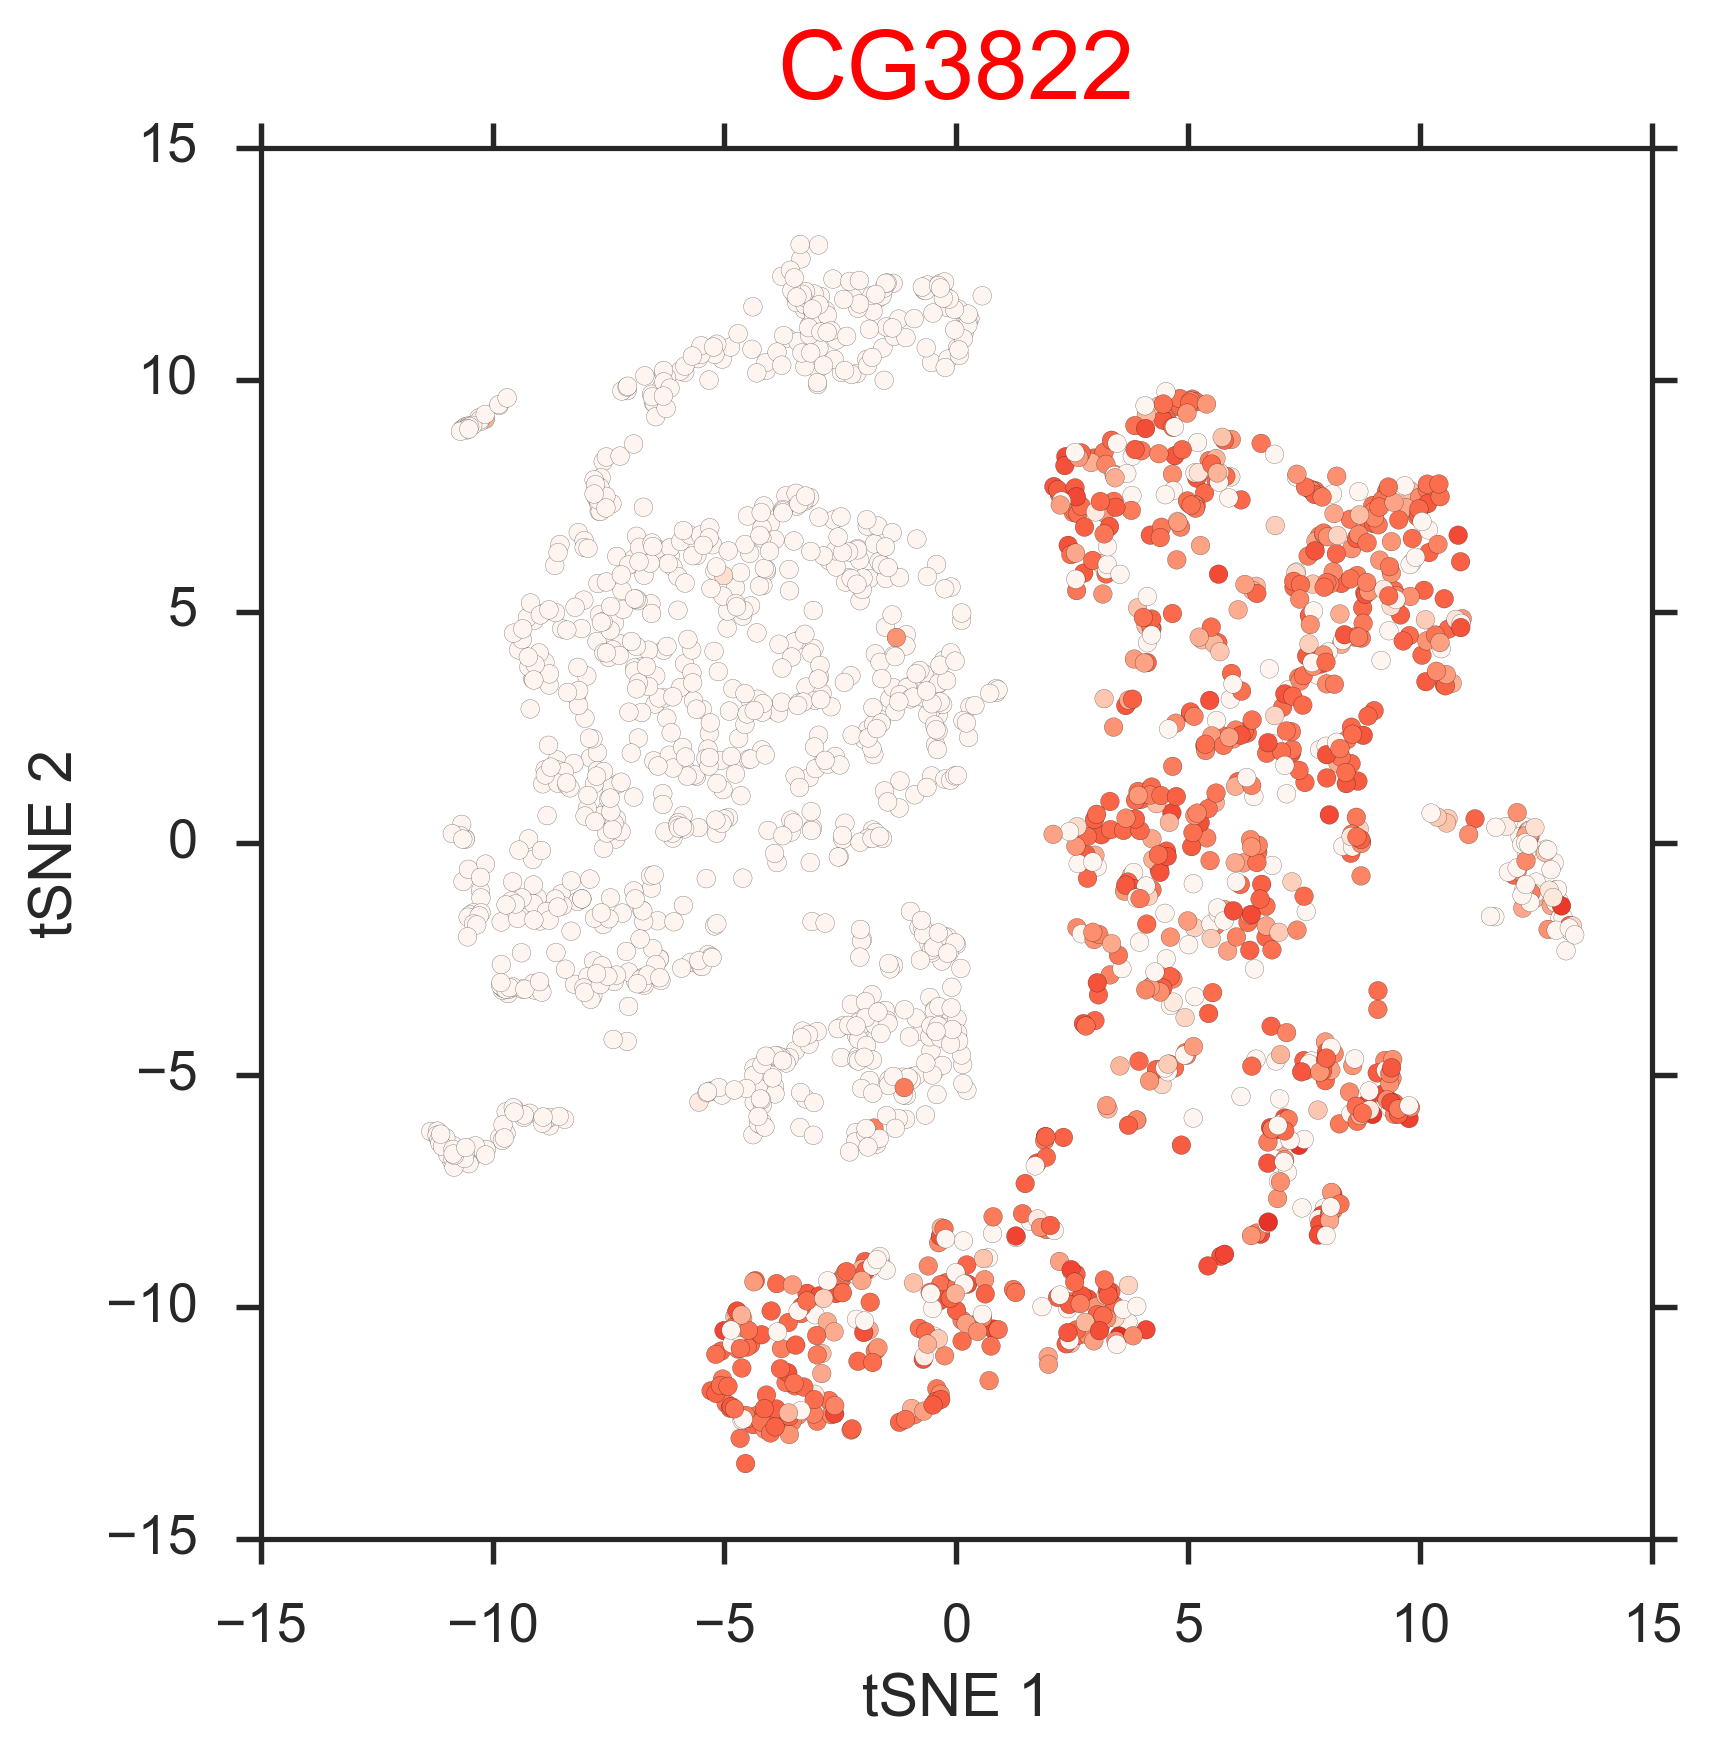

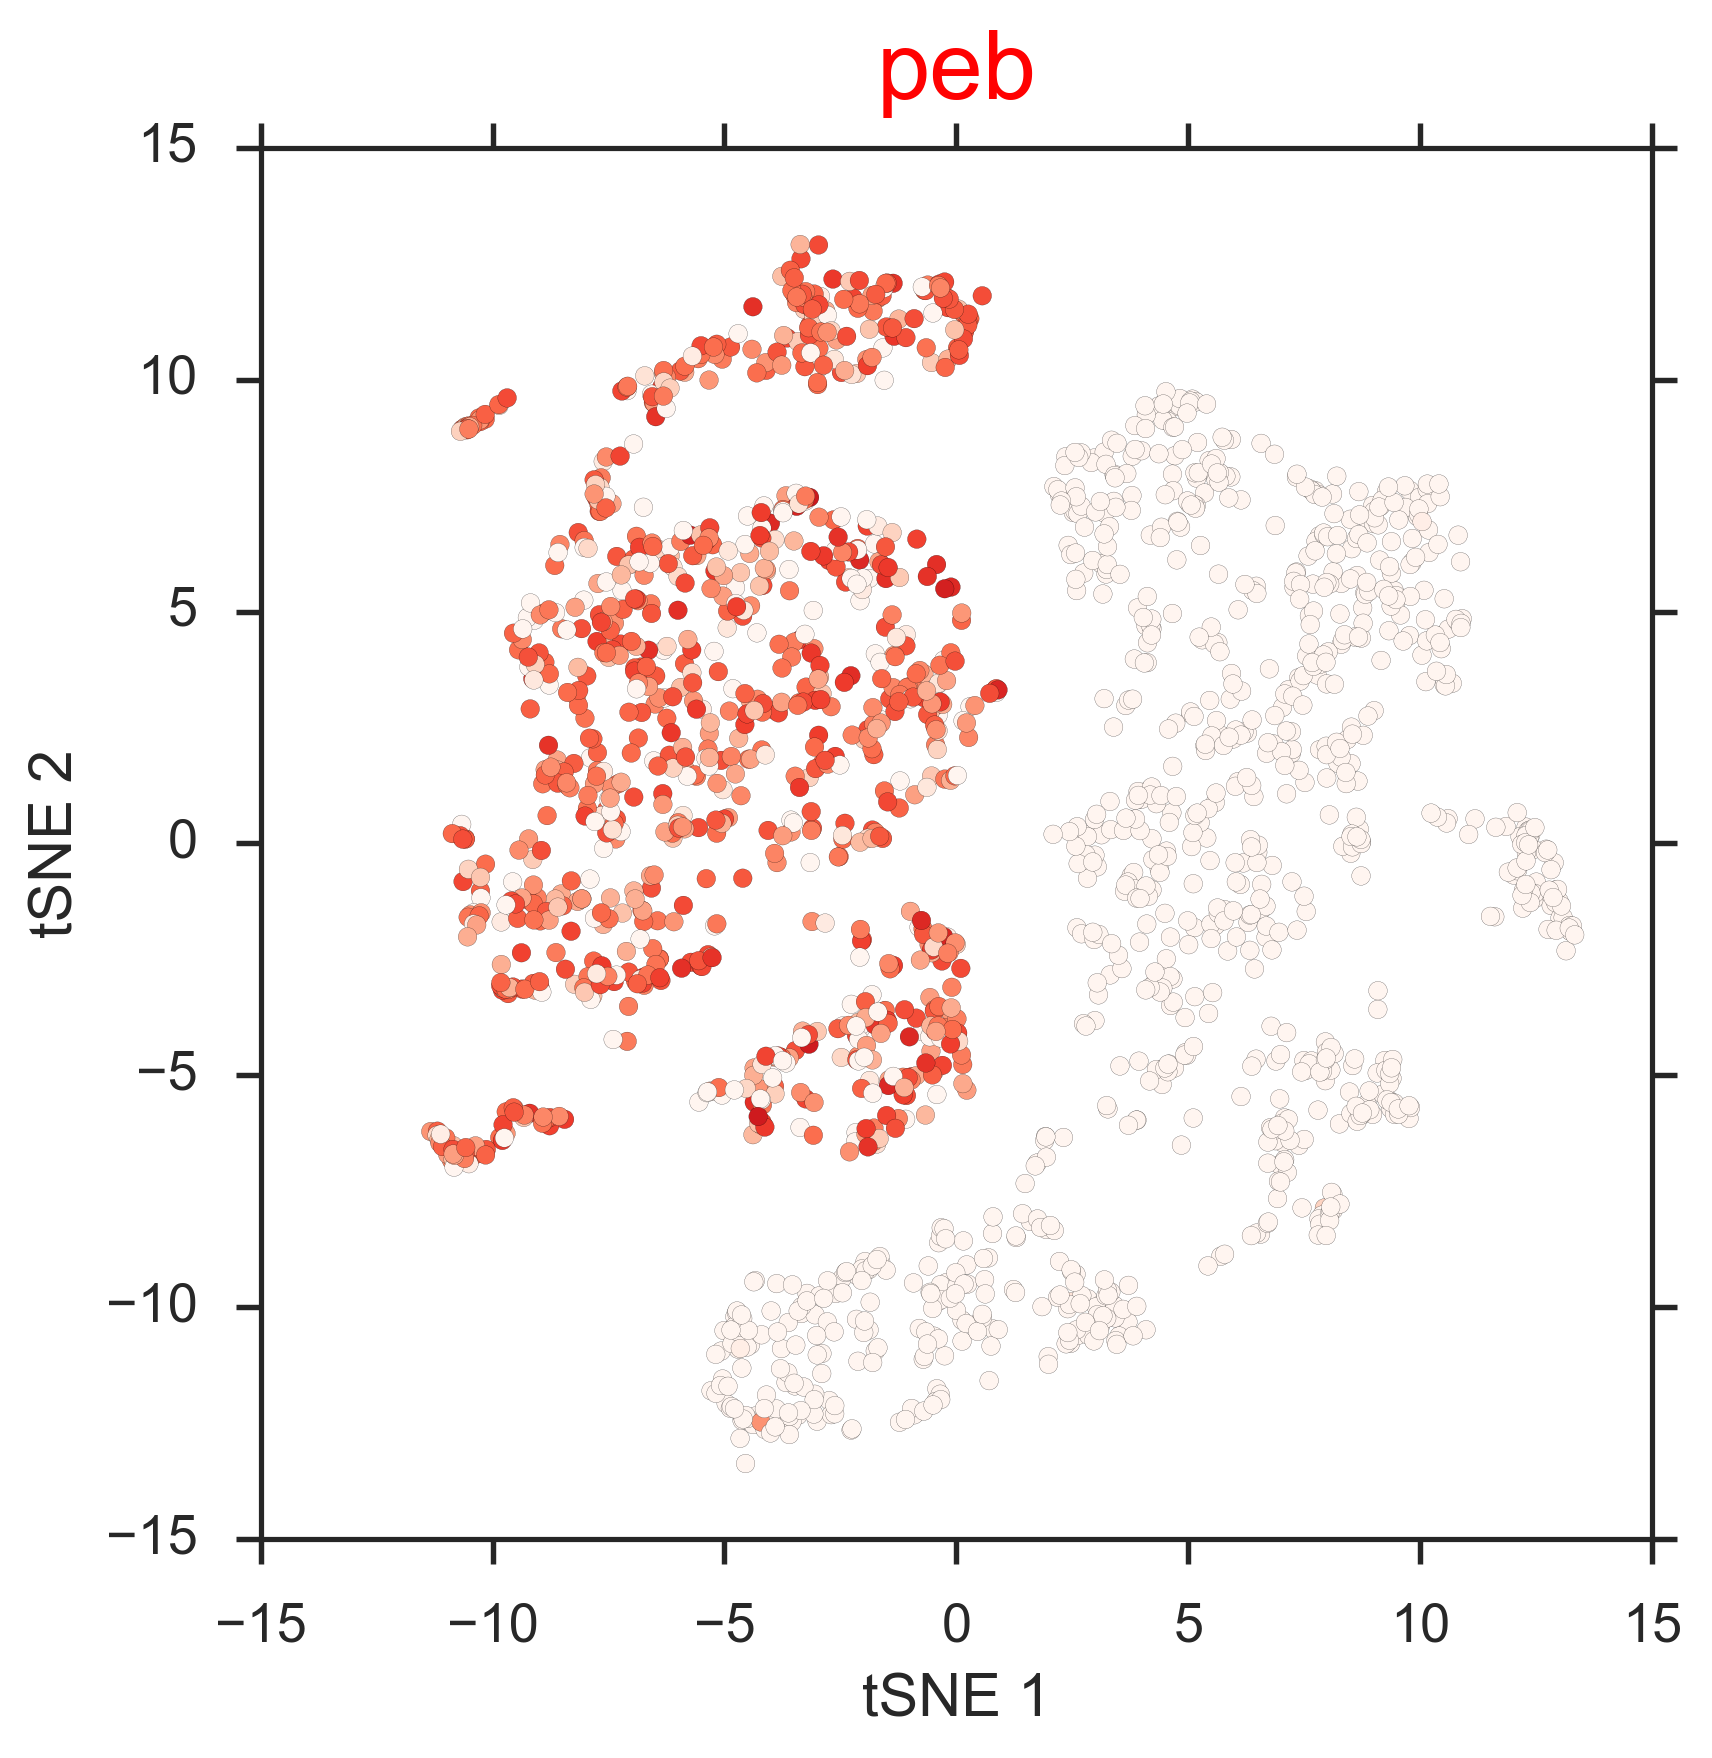

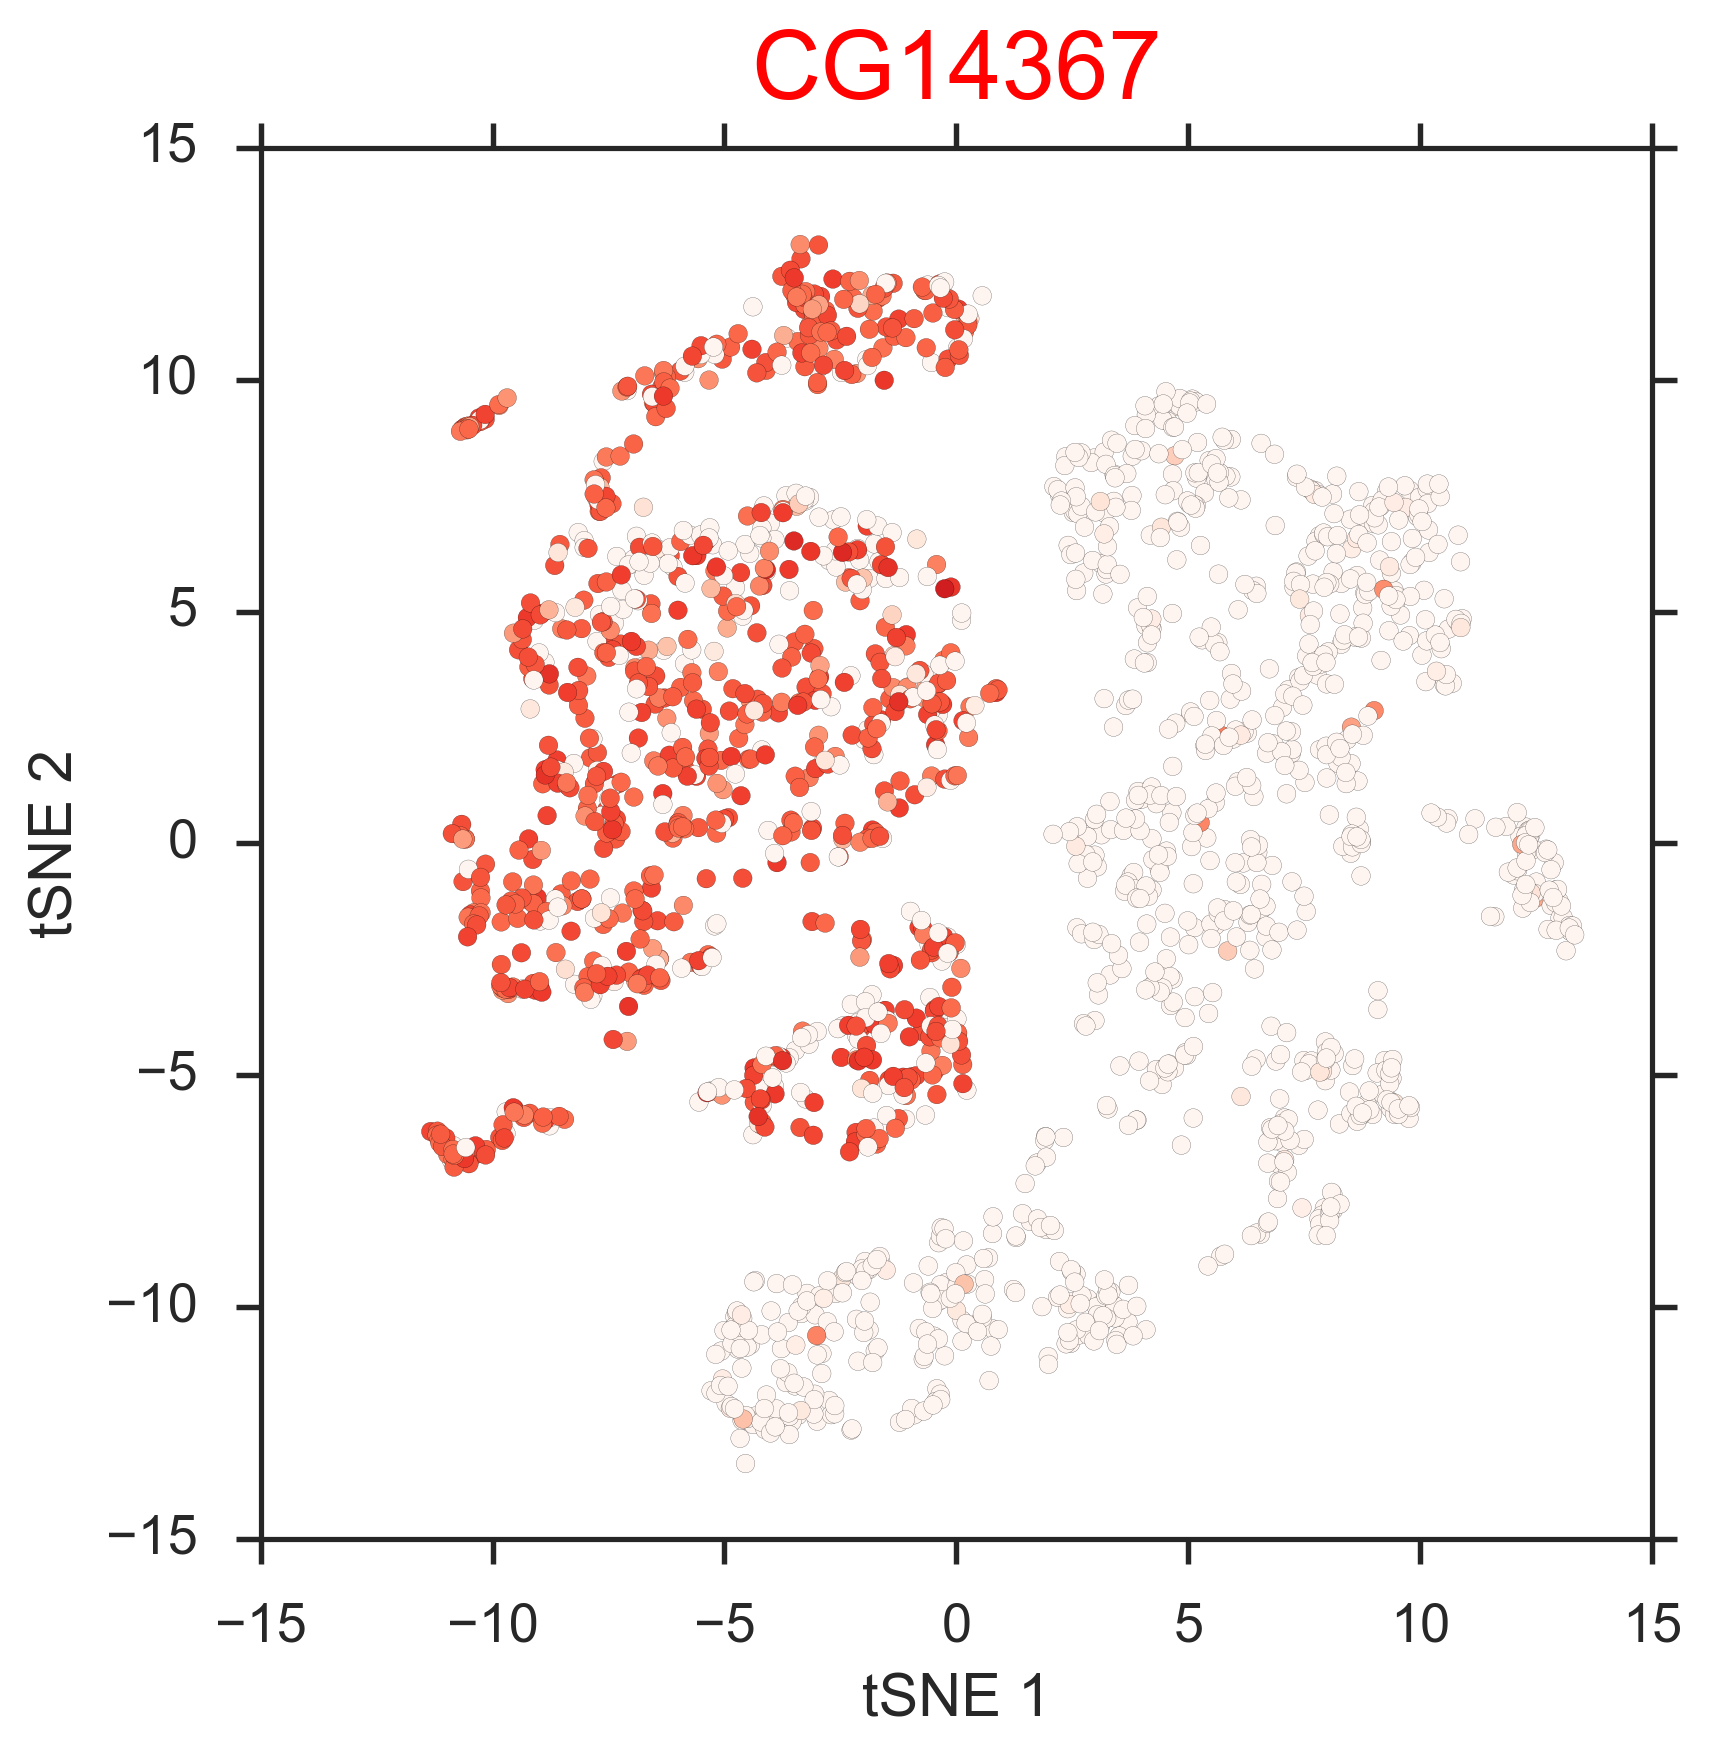

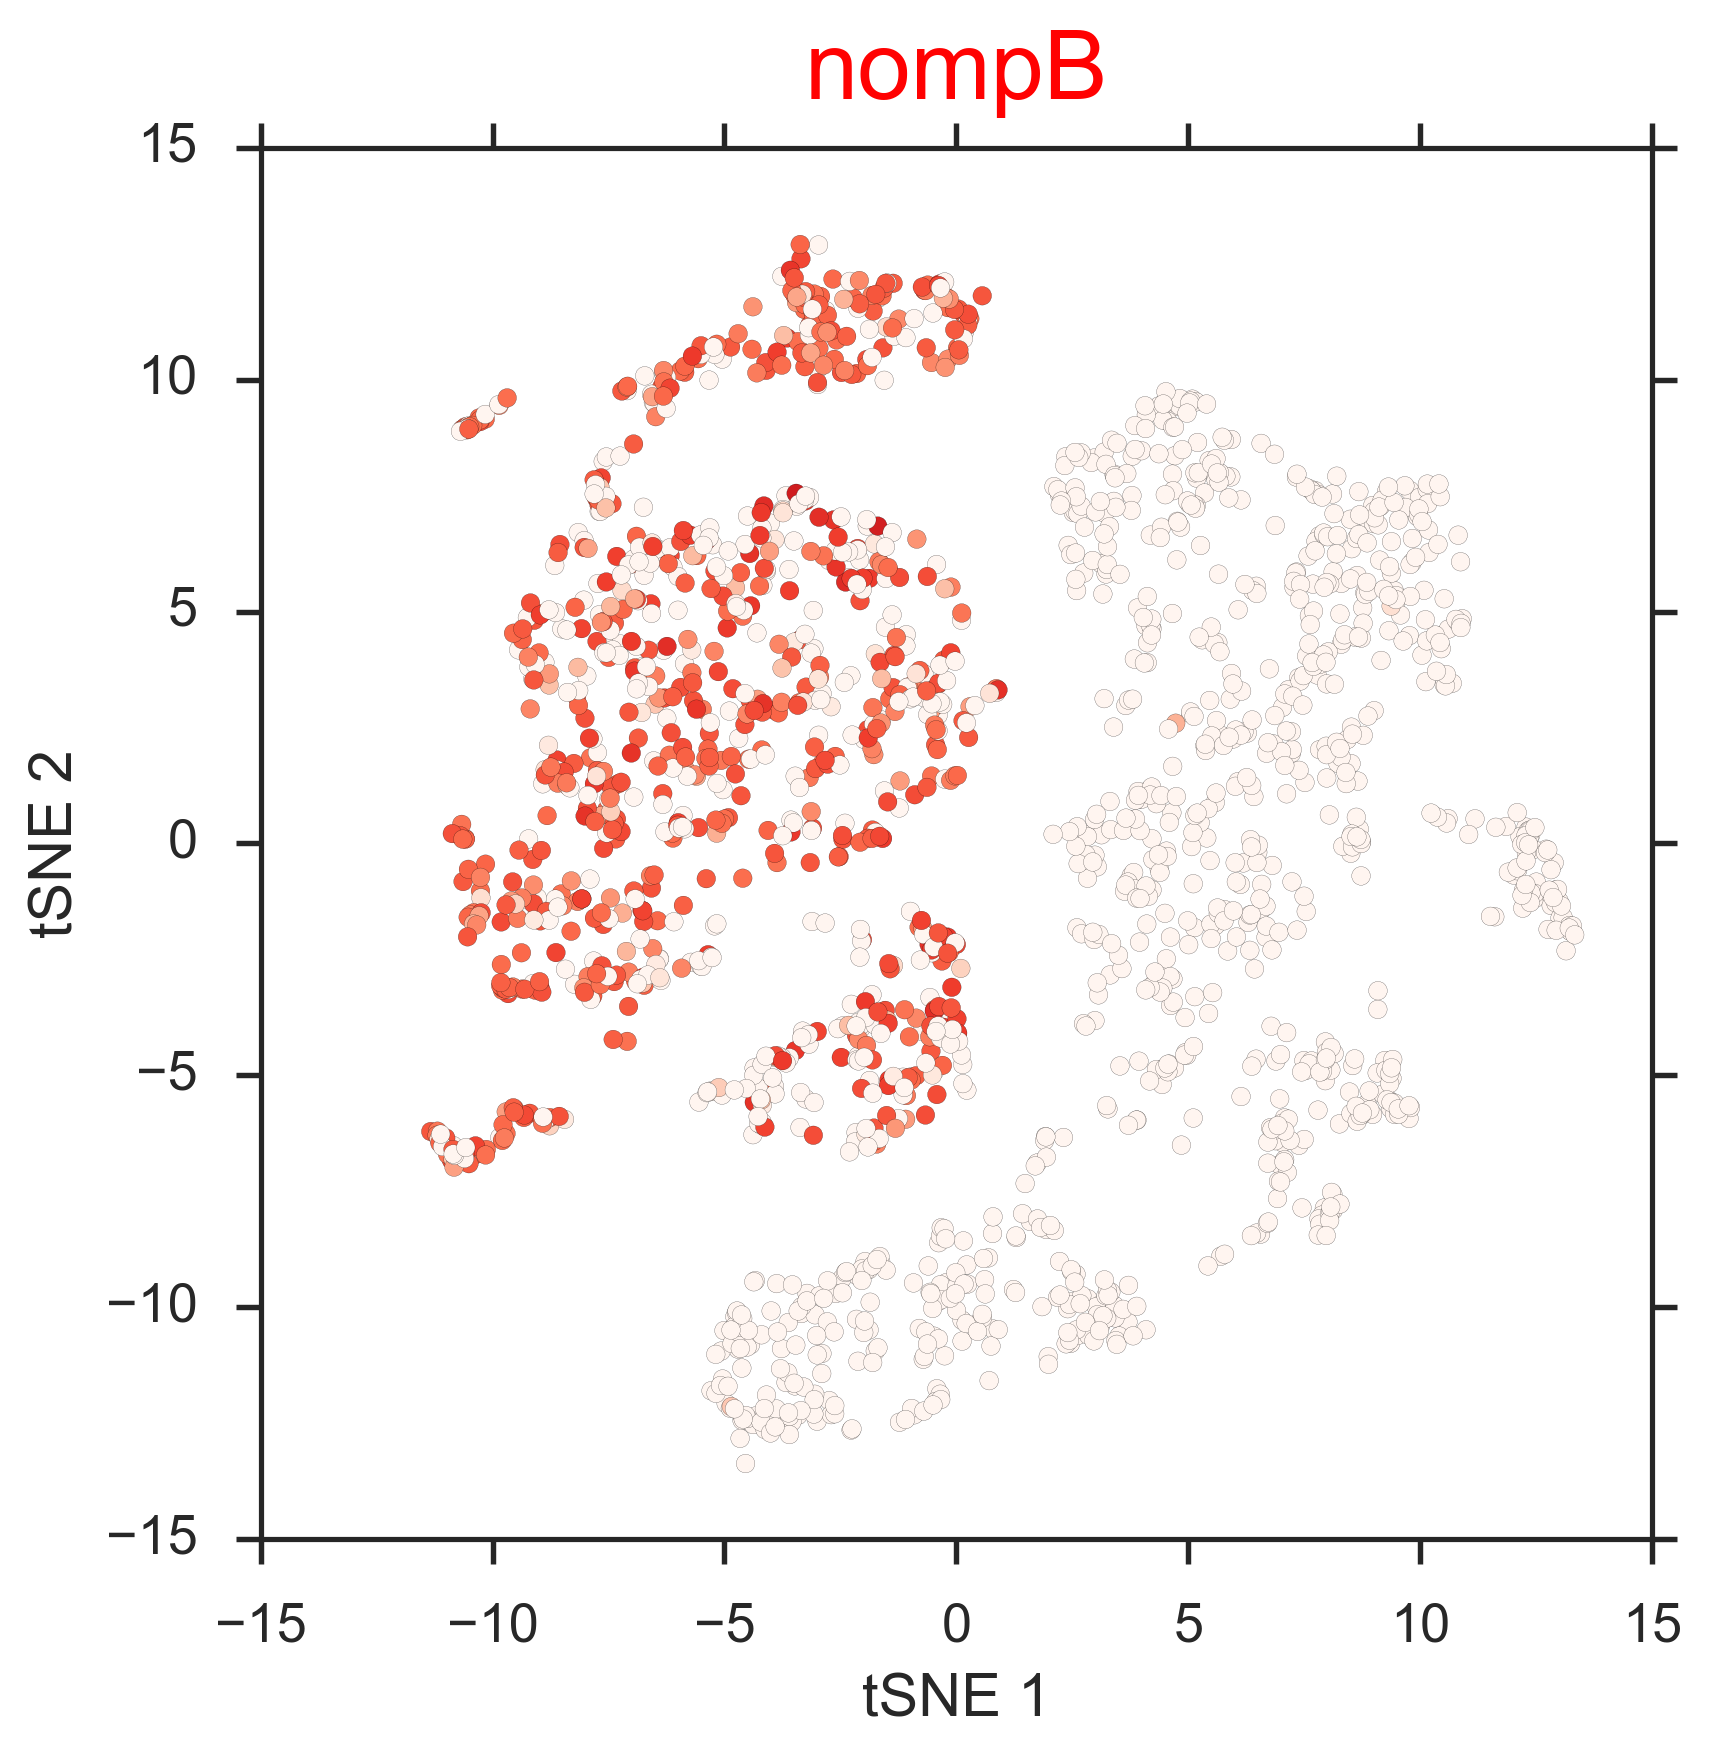

In [15]:
for gene in myGenes:
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    sc = myTSNE.plot(fig, ax, colorBy=gene, cmap="Reds")
    ax.set_aspect("equal")
    ax.set_title(gene, color ="r", size= 23, y= 1.02)
    plt.tight_layout()
    fig.savefig("../Figure/Fig_1/Fig1_ORN_PN_" + gene +  ".pdf")

# Heatmap of PN and ORN 

In [16]:
df_libs = pd.read_csv("../data/libs_color3_PN_ORN.csv", sep=",", header=0, index_col=0) # sample info

# using over dispersed genes

In [17]:
# Get top overdispersed genes
myDispersion = sct.dispersion(X_PN_ORN)
myDispersion.calc_dispersion() # calculate overdispersion

genes_overdispersed = myDispersion.get_hits(N=1000) #top 100 genes

print genes_overdispersed.index

Index([u'Tsp42Ef', u'GstE4', u'zfh2', u'kn', u'unpg', u'Ir25a', u'GstS1',
       u'Hsp23', u'CG13578', u'Nep1',
       ...
       u'CG6398', u'CG32483', u'tilB', u'Hem', u'CG7386', u'l(1)G0045',
       u'CR33294', u'CG4462', u'CG3335', u'CG5955'],
      dtype='object', name=u'symbol', length=1000)


In [19]:
# Save overdispersed genes into files
with open("../data/names_overdispersed_genes_PN_ORN_1000.txt", 'w') as out:
    for x in genes_overdispersed.index:
        out.write(x + "\n")

In [20]:
names_genes_overdispersed = []
with open ("../data/names_overdispersed_genes_PN_ORN_1000.txt") as f:
    for line in f:
        names_genes_overdispersed.append(line.rstrip())
        
len(names_genes_overdispersed)

1000

In [21]:
# select N overdispersed genes
Z = X_PN_ORN.loc[names_genes_overdispersed[0:100]]
print Z.shape

(100, 1992)


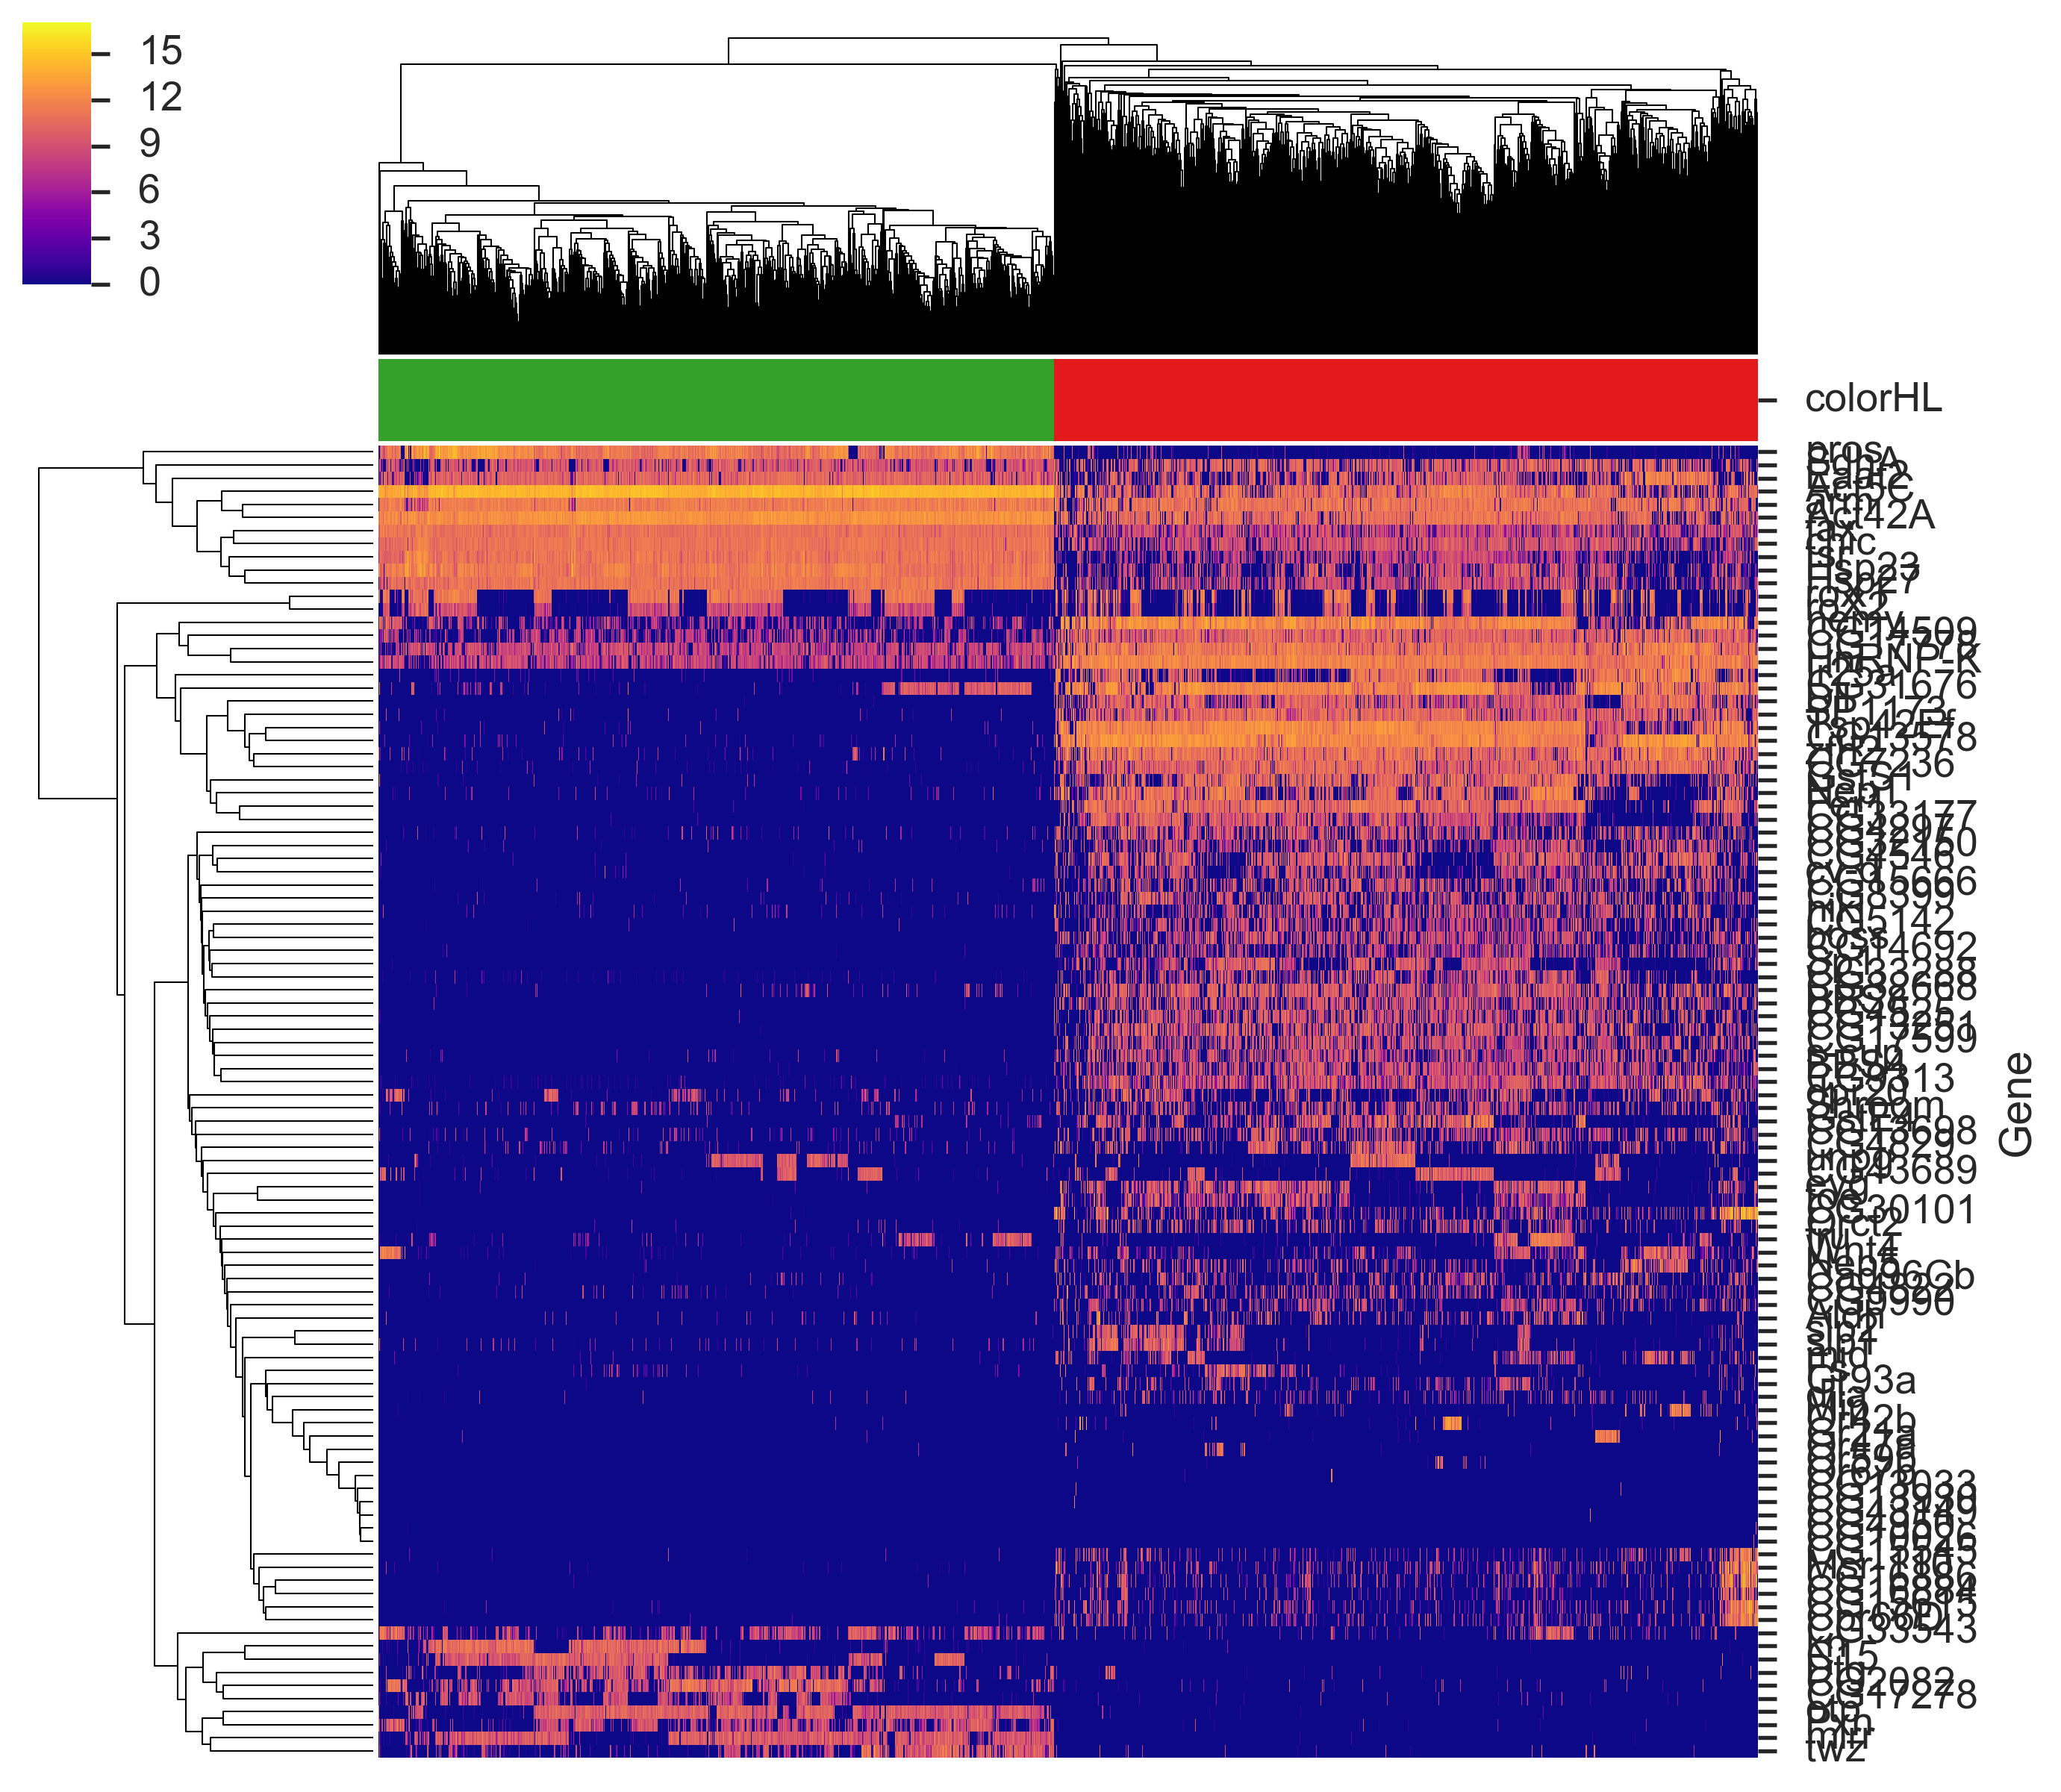

In [22]:
# Calculate clustering and plot
col_colors = df_libs.loc[Z.columns]["colorHL"]
# cm = sns.clustermap(Z, metric="correlation", method="average", cmap="magma", figsize=(12,4), col_colors=col_colors)
cm = sns.clustermap(Z, method="average", cmap="plasma", figsize=(10,10), col_colors=col_colors, row_cluster=True, col_cluster=True)
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cm.ax_heatmap.set_ylabel("Gene")
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.set_xticklabels([])
cm.savefig("../Figure/Fig_1/Fig1_heatMap_top_100_overdispersed_genes.pdf")

# using differentially expressed genes

In [24]:
X = X_PN_ORN
X.shape

(15908, 1992)

In [ ]:
#This may take more than 10min
df_DE_ORN_PN = sct.calc_DE_mannwhitneyu(X, names_PN, names_New_ORN)


print "done!"

In [ ]:
# Save data
df_DE_ORN_PN.to_csv("../data_paper/df_DE_ORN_PN.csv")

In [25]:
# reload data
df_specificGenes = pd.read_csv("../data/df_DE_ORN_PN.csv", header=0, index_col=0)
df_specificGenes.index[0:100]

Index([u'CR40469', u'Tsp42Ef', u'pros', u'nAChRbeta1', u'CG13578', u'Oaz',
       u'Hsp67Ba', u'zfh2', u'Act5C', u'SP1173', u'CG7236', u'CG34309',
       u'CG32006', u'nAChRalpha7', u'tnc', u'tsr', u'CR43481', u'peb', u'Hr4',
       u'nAChRbeta2', u'CG15704', u'HnRNP-K', u'CG42336', u'Act42A', u'Hsp23',
       u'Dll', u'cpo', u'CG15765', u'CG14312', u'dnd', u'Fer1', u'CG31676',
       u'chic', u'sn', u'Hsp27', u'FK506-bp2', u'fax', u'Task6', u'Alk',
       u'CG9313', u'CG3822', u'A2bp1', u'Atpalpha', u'CG42613', u'CG17270',
       u'CG2862', u'Nlp', u'nAChRalpha6', u'nAChRalpha2', u'CG4300', u'Oli',
       u'mirr', u'GluClalpha', u'CG17778', u'CG6044', u'GstS1', u'Hs3st-B',
       u'CG34417', u'CG14509', u'Fpps', u'otp', u'CG14367', u'nemy',
       u'Ssb-c31a', u'Rpb11', u'CG1943', u'Idh', u'Sod', u'bru-2', u'Non2',
       u'Nrk', u'Cnx14D', u'CG12643', u'BBS4', u'Dscam4', u'CG32668',
       u'CG13251', u'Nlg2', u'BBS8', u'CG33177', u'CG17599', u'tup', u'Ir25a',
       u'Fas1', u'Jupit

In [26]:
Z = X_PN_ORN.loc[df_specificGenes.index[0:100]]
print Z.shape

(100, 1992)


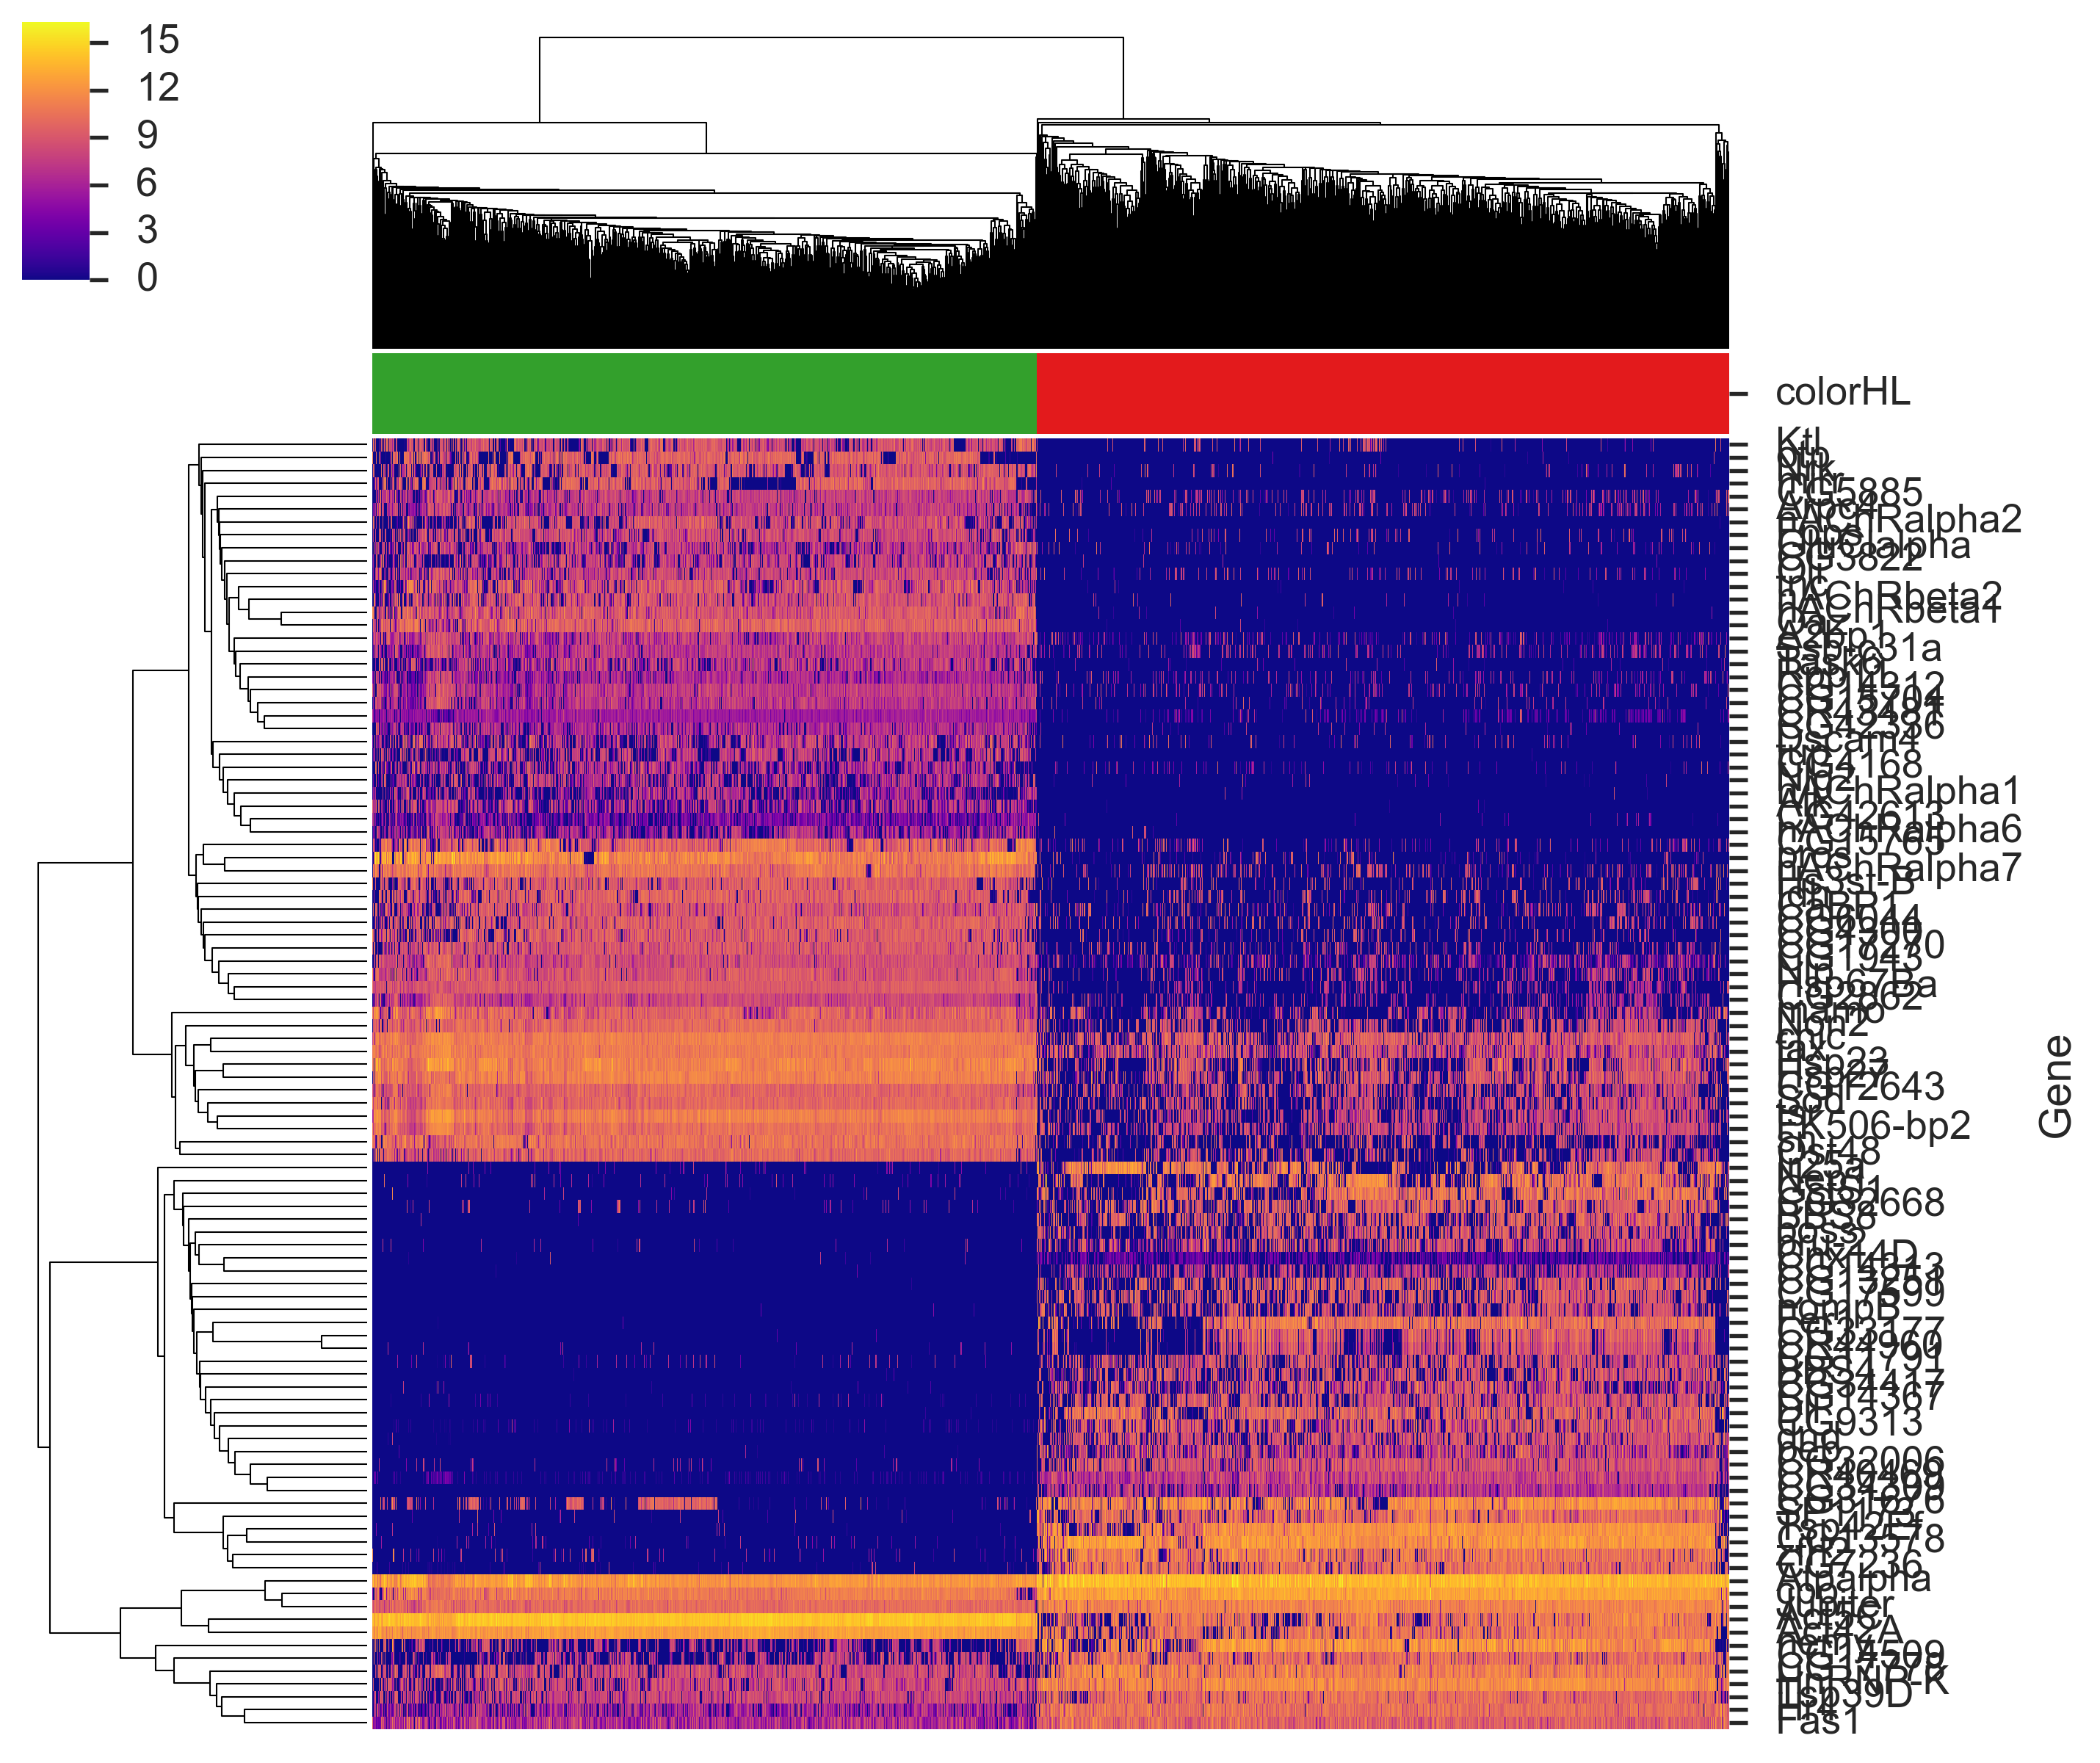

In [27]:
# Calculate clustering and plot
col_colors = df_libs.loc[Z.columns]["colorHL"]
# cm = sns.clustermap(Z, metric="correlation", method="average", cmap="magma", figsize=(12,4), col_colors=col_colors)
cm = sns.clustermap(Z, method="average", cmap="plasma", figsize=(10,10), col_colors=col_colors, row_cluster=True, col_cluster=True)
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cm.ax_heatmap.set_ylabel("Gene")
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.set_xticklabels([])
cm.savefig("../Figure/Fig_1/Fig1_heatMap_top_100_DE_genes.pdf")

In [28]:
X = df_All_ORN
X.shape

(15908, 1016)

In [29]:
#specific genes in 2nd segment of the antenna
MyGenes = ["Act5C","nSyb","Arr2","Pdh","Gbeta76C","CG1561","Rh4","se","retinin"]
Z = X.loc[MyGenes]

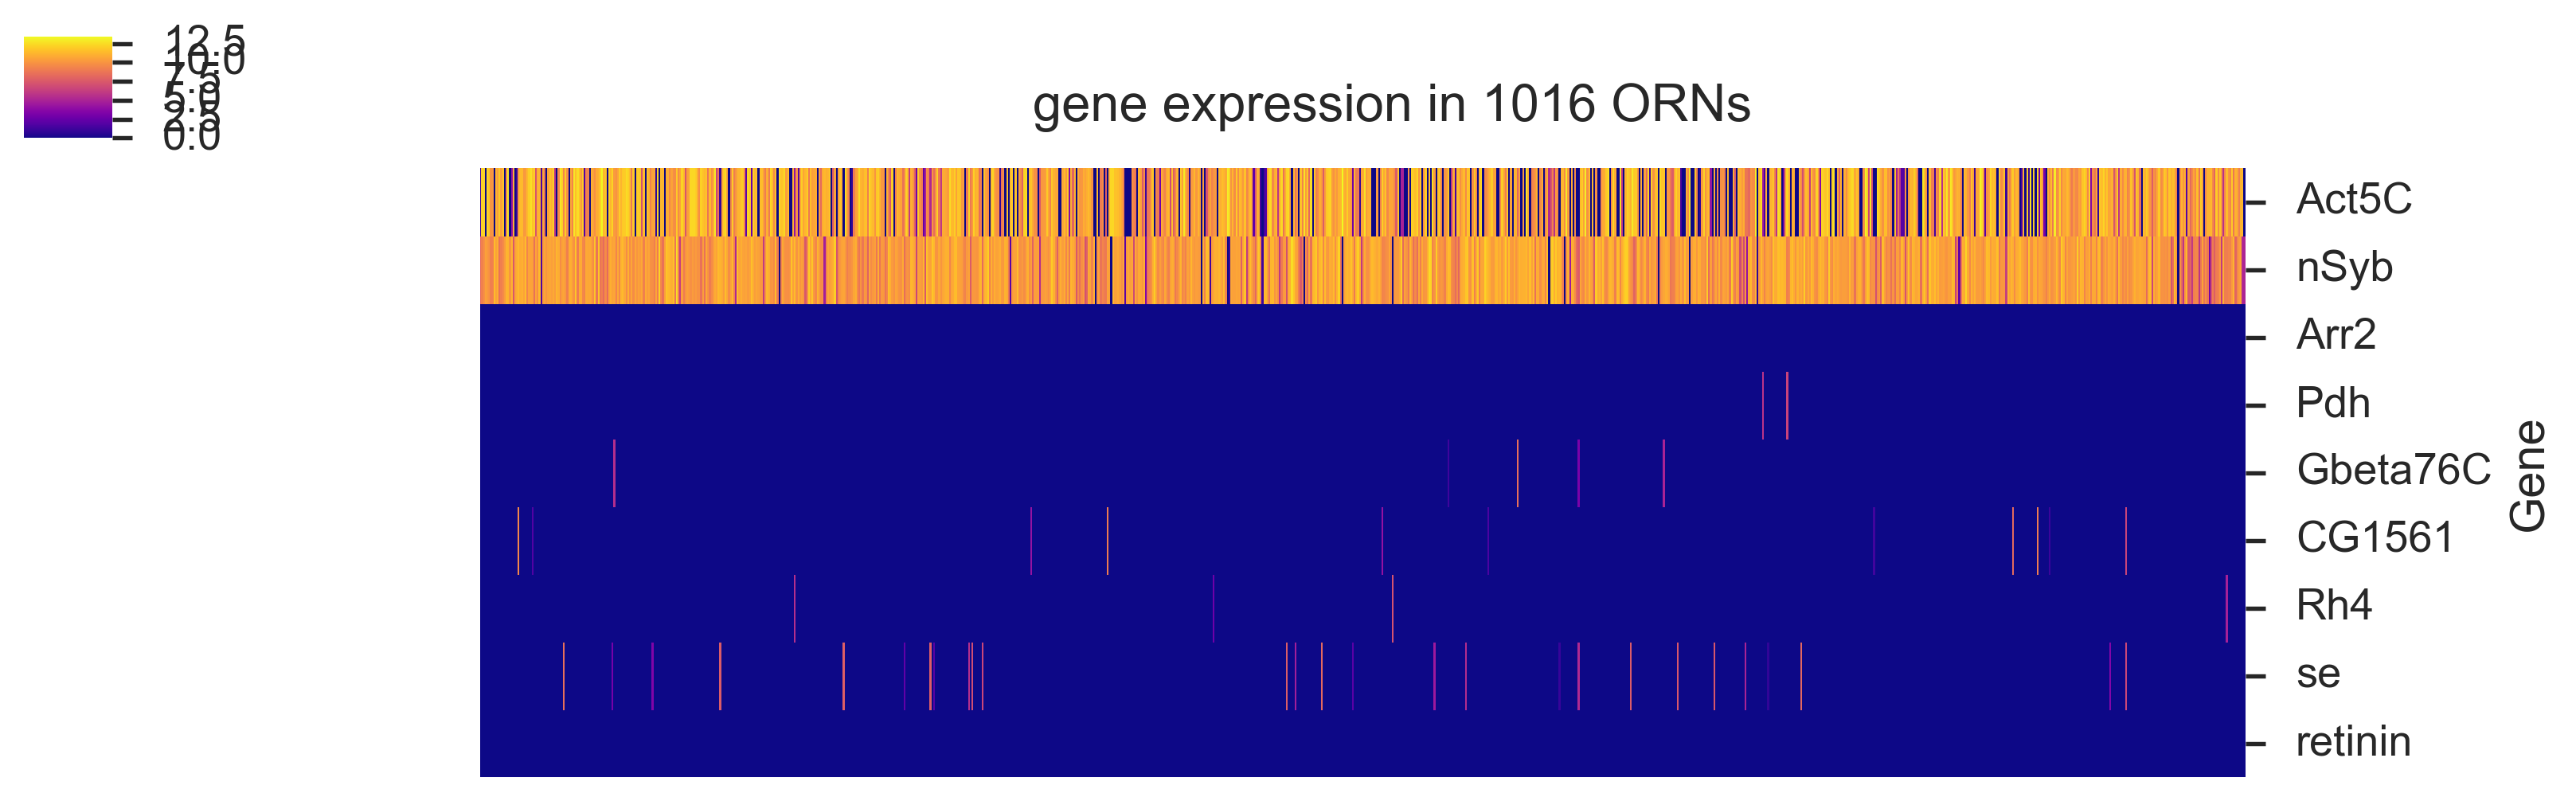

In [30]:
col_colors = df_libs.loc[Z.columns]["colorHL"]
cm = sns.clustermap(Z, method="average", cmap="plasma", figsize=(12,4), row_cluster=False, col_cluster=False)
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.title("gene expression in 1016 ORNs", x=15.5, y= 0.01)
cm.ax_heatmap.set_ylabel("Gene")
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.set_xticklabels([])
cm.savefig("../Figure/Fig_1/Fig1_heatMap_Antennal_genes.pdf")

# Expression level and dropout rate: all genes and marker genes


In [32]:
dropout_threshold = 3

In [35]:
df = df_All_ORN
df.shape

(15908, 1016)

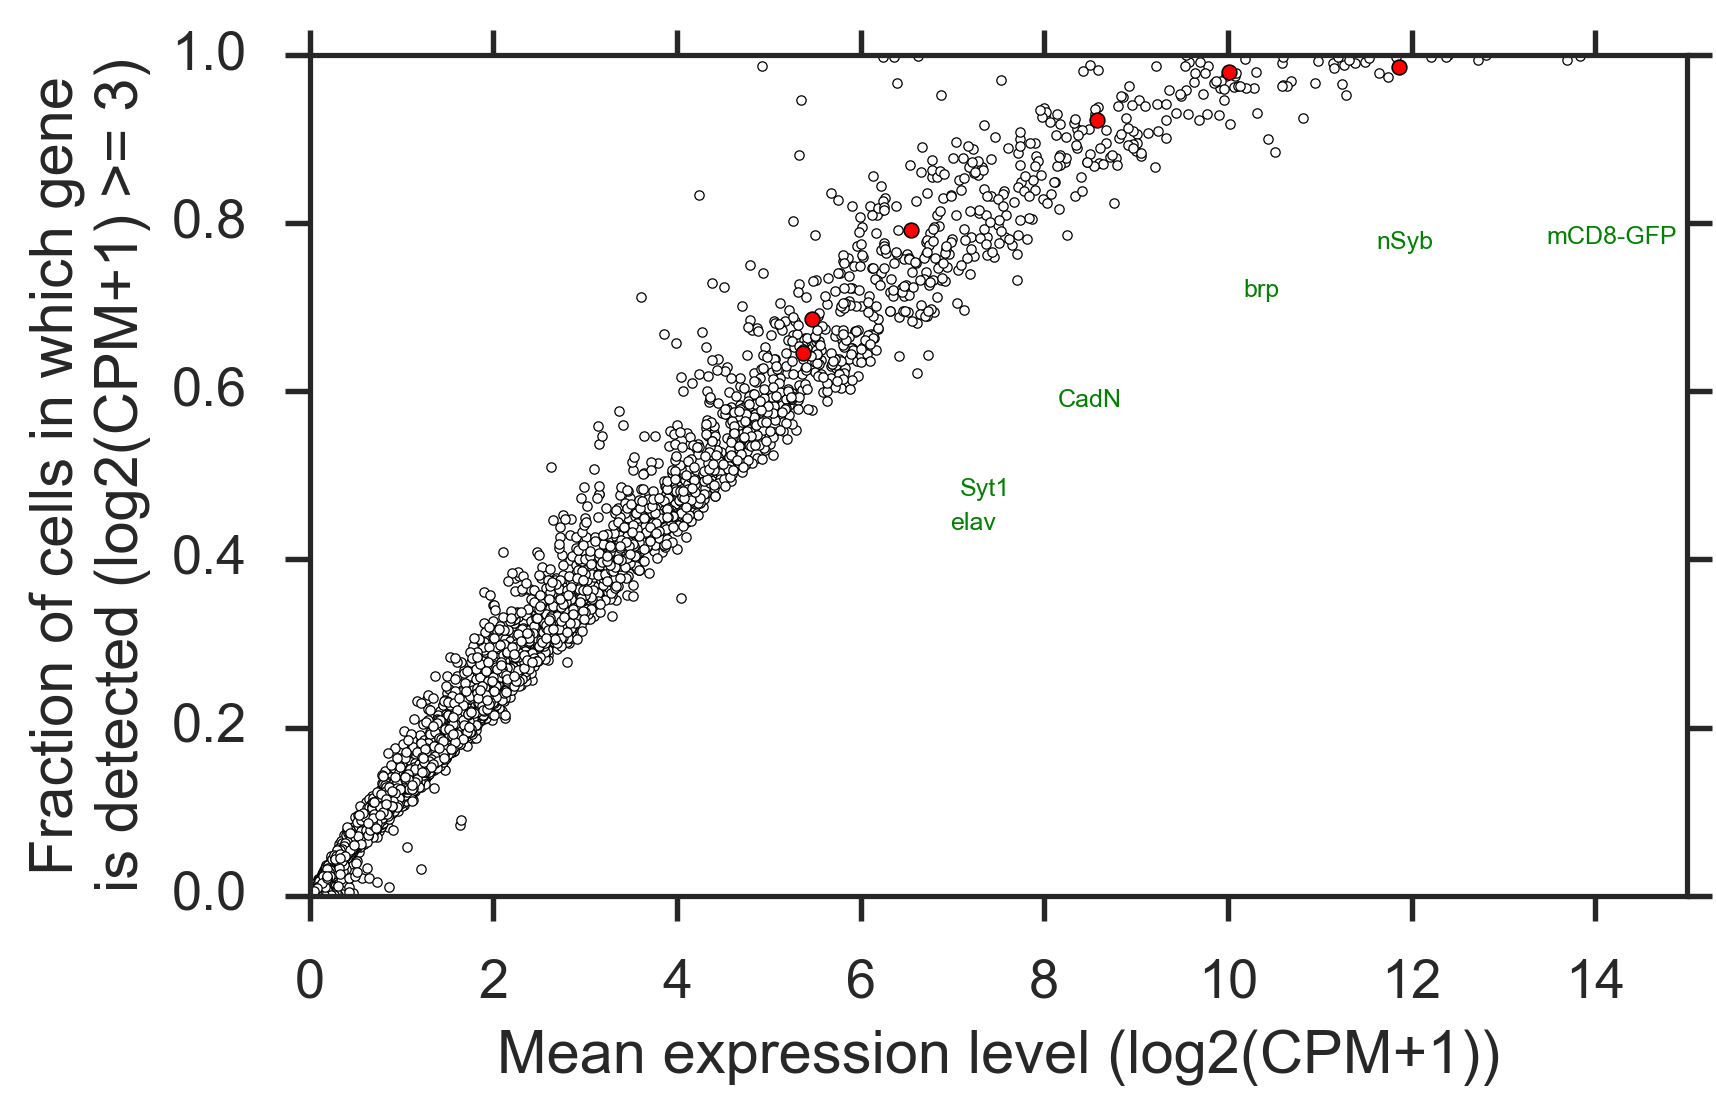

In [37]:
# What is the dropout rate of the marker genes used to filter cells?

genes = ["mCD8-GFP", "elav", "brp", "Syt1", "nSyb", "CadN"]
#genes_neuron_marker = ["Act5C","mCD8-GFP", "nSyb"]

dropout_rate = np.sum(df >= dropout_threshold, axis=1) / df.shape[1]

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.set_xlim(1, 15)

x = np.mean(df, axis=1)
y = dropout_rate
ax.scatter(x, y, marker=".",linewidths=0.3, c = 'white')

x = np.mean(df, axis=1).loc[genes]
y = dropout_rate.loc[genes]
ax.scatter(x, y, marker=".", c="r", s=50)

ax.set_xlim(left=0)
ax.set_ylim(0,1)
ax.set_xlabel("Mean expression level (log2(CPM+1))")
ax.set_ylabel("Fraction of cells in which gene\nis detected (log2(CPM+1) >= 3)")

for myX, myY, label in zip(x, y, x.index):
    ax.text(myX+1.6, myY-0.21, label, color='g',fontsize=6)
    
plt.tight_layout()

fig.savefig("../Figure/Fig_S1/FigS1_genes_dropout_filter_markers_ORN.pdf")

# Read distribution and gene detection distribution

In [40]:
df_star = pd.read_csv("../data/STAR.tab", sep="\t", header=0, index_col=0)
df_star.shape
#df_star

(4390, 6)

In [41]:
df_star_PN = df_star.loc[names_PN]
df_star_ORN = df_star.loc[names_All_ORN]

print "all PN:", df_star_PN.shape
print "all ORN:", df_star_ORN.shape

all PN: (976, 6)
all ORN: (1016, 6)


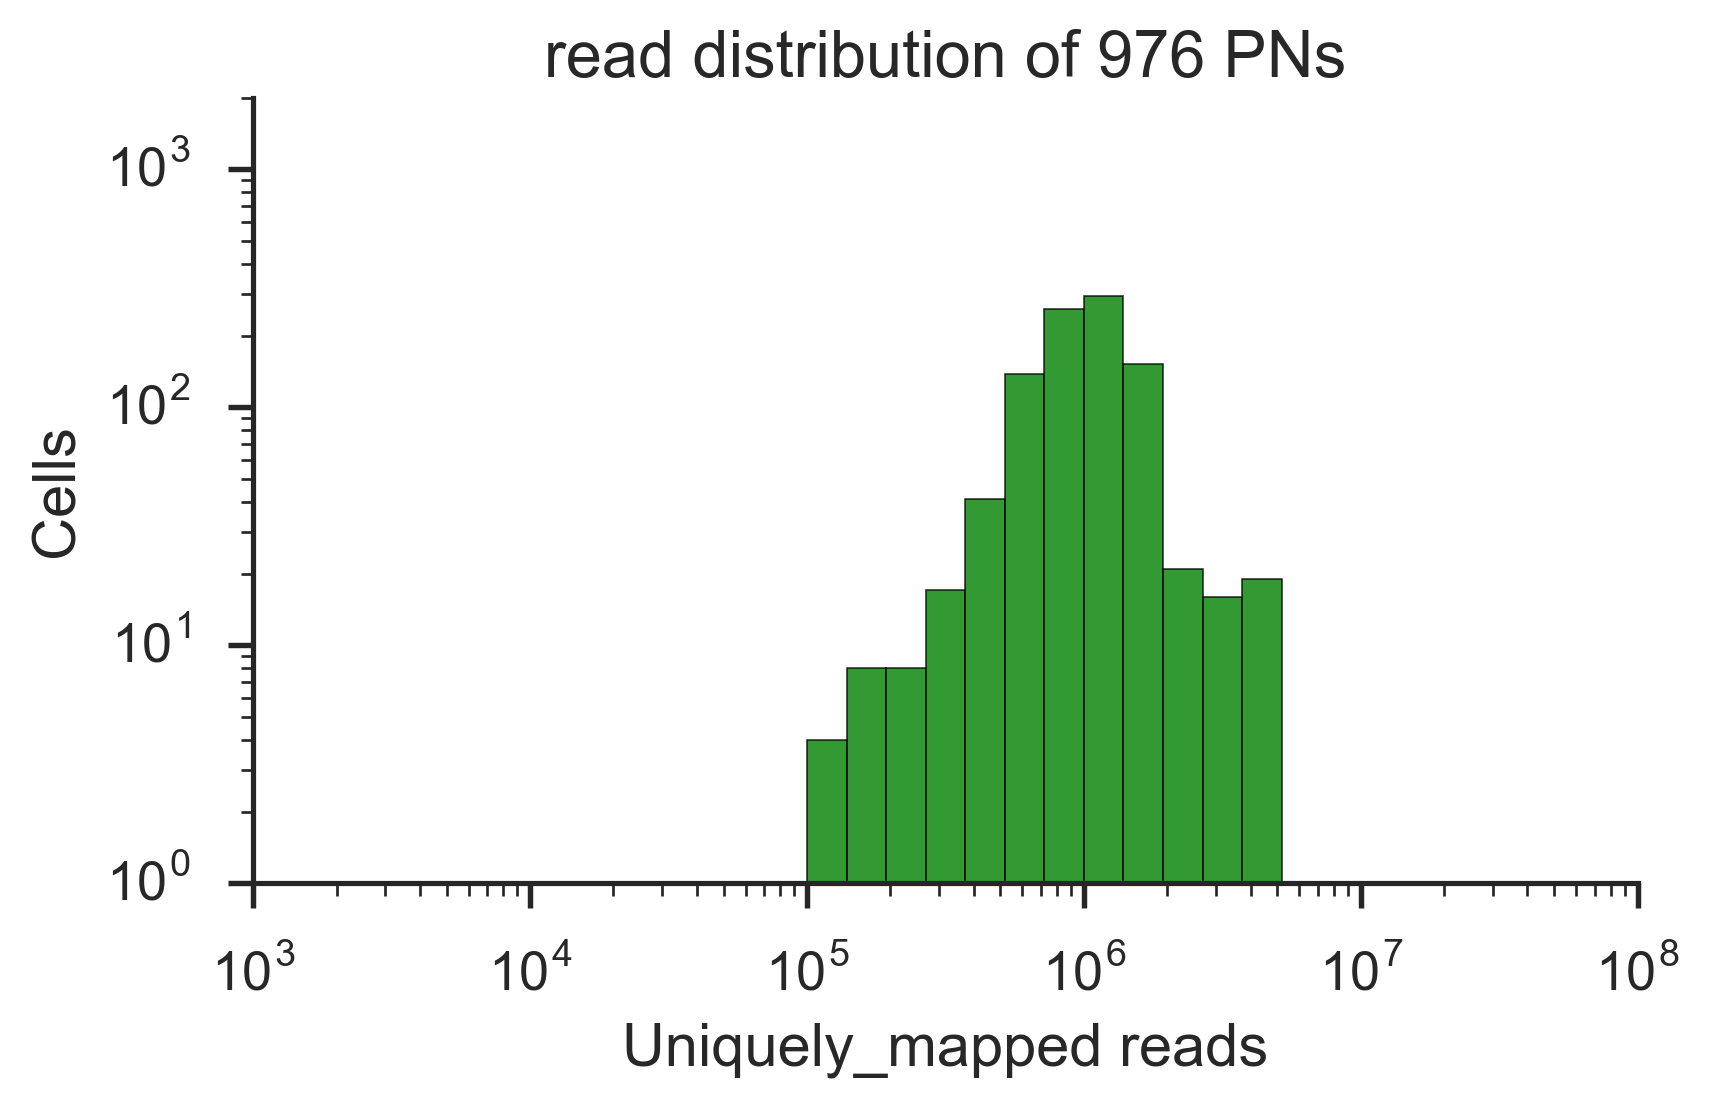

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.hist(df_star_PN["uniquely_mapped"], bins=np.logspace(0,7,50), color=['green'],alpha = 0.8) #'crimson', 'burlywood', 'chartreuse'
plt.title("read distribution of 976 PNs")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1, 2e3)
ax.set_xlim(1000, 1e8)
ax.set_xlabel("Uniquely_mapped reads")
ax.set_ylabel("Cells")
sns.despine()
plt.tight_layout()
fig.savefig("../Figure/Fig_S1/FigS1_reads_distribution_PN.pdf")

In [44]:
df = df_All_ORN
df1 = df[df >= 3.0].count() #Log(CPM+1)>=2, CPM >= 3

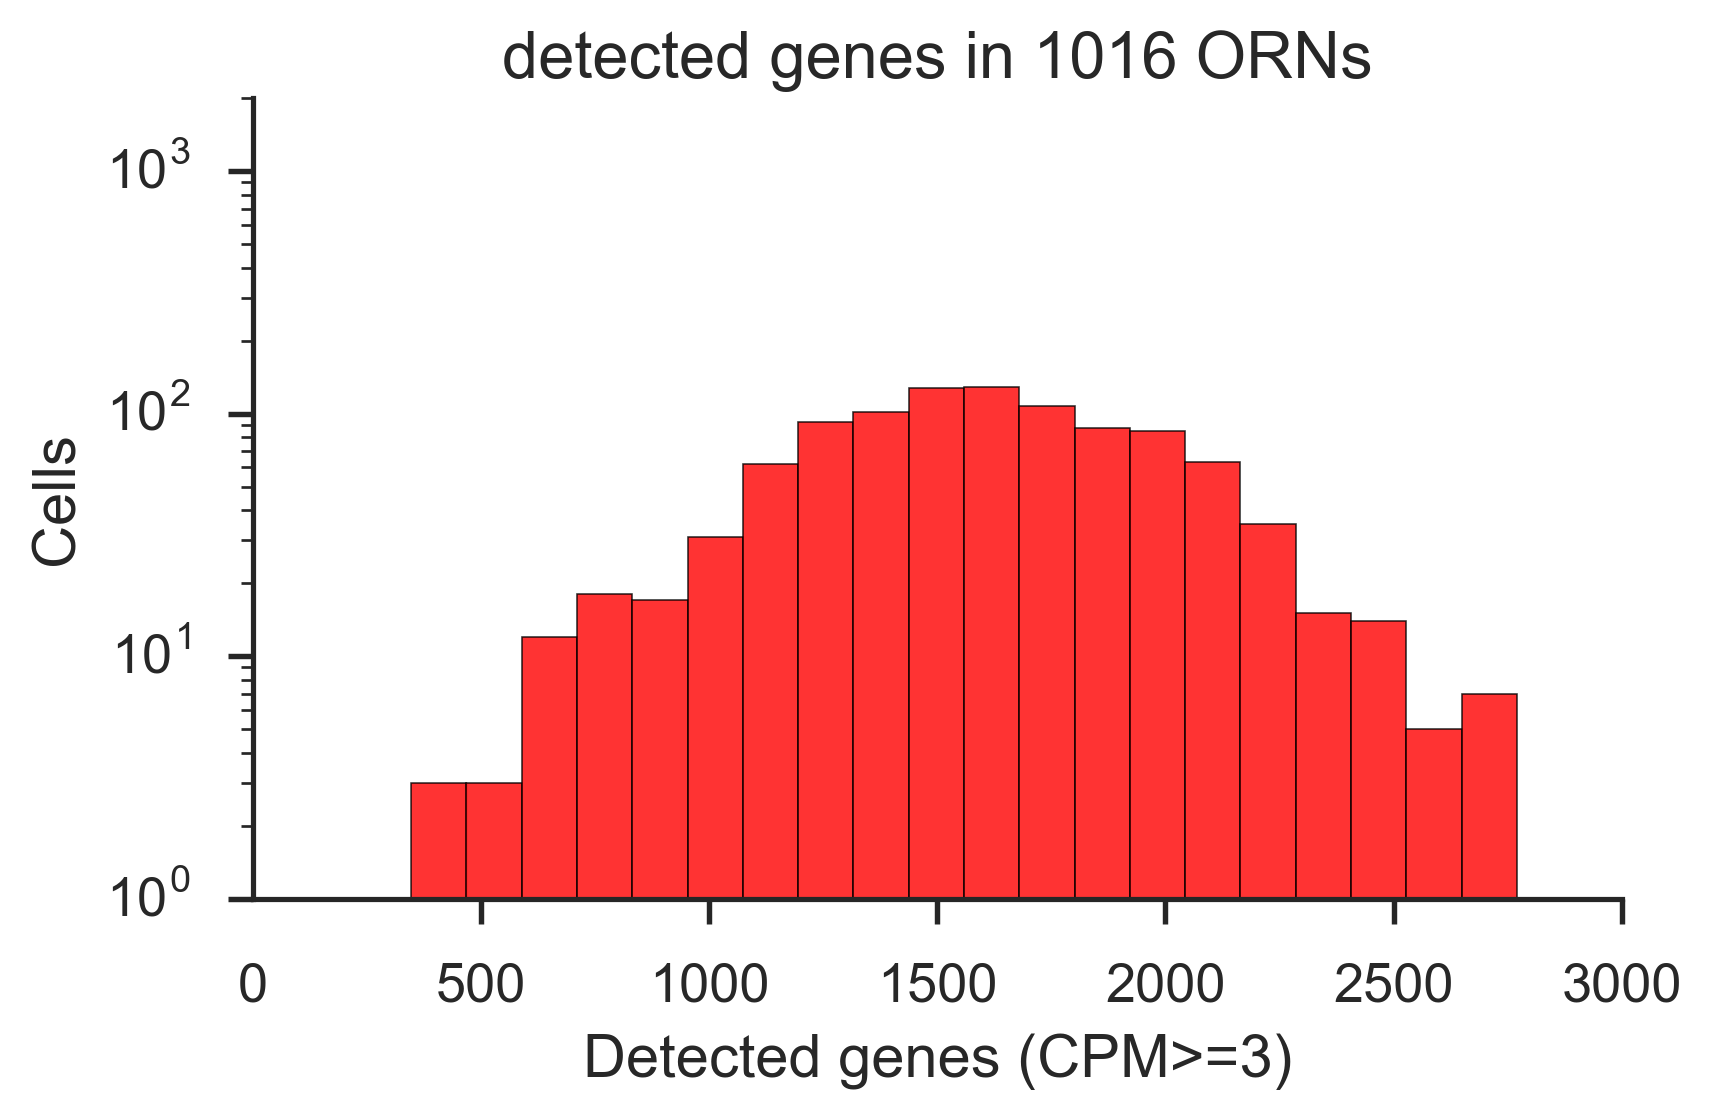

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.hist(df1, 20, color=['r'],alpha = 0.8) #'crimson', 'burlywood', 'chartreuse'

plt.title("detected genes in 1016 ORNs")
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1, 2e3)
ax.set_xlim(1, 3000)
ax.set_xlabel("Detected genes (CPM>=3)")
ax.set_ylabel("Cells")
sns.despine()
plt.tight_layout()
fig.savefig("../Figure/Fig_S1/FigS1_genes_detected_ORN.pdf")